In [1]:
#!/usr/bin/py
import sklearn
import logging
import os
import warnings
import numpy as np
import tsfel
from collections import namedtuple
from contextlib import contextmanager
from datetime import datetime
from zipfile import ZipFile, is_zipfile
import matplotlib.pyplot as plt
import pandas as pd
import math
import tsfresh.feature_extraction.feature_calculators as feature
from tsfresh.utilities.distribution import MultiprocessingDistributor
import seaborn as sns

In [2]:
HEADER_LINE_PREFIX = '% '
HEADER_END_LINE_PREFIX = '%-'
HEADER_KEYS = ['date_time', 'prog_version', 'serial', 'mech_unit', 'axis', 'sampling_period', 'tool', 'rob_ax', 'ext_ax']
DATETIME_FORMAT = '%Y%m%d_%H%M%S'

MIN_SAMPLES = 600
SAMPLING_PERIOD = 0.004032
FREQUENCY = 1/SAMPLING_PERIOD

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()



In [3]:
MccRun = namedtuple('MccRun', 'mode series')
MccResult = namedtuple('MccResult', 'status value average distance')
OperationMode = namedtuple('OperationMode', ['axis', 'mech_unit', 'tool', 'rob_ax', 'ext_ax', 'prog_version'])

In [4]:
@contextmanager
def open_zip(file):
    if not is_zipfile(file):
        raise TypeError(f'{file} is not a valid zip file')

    zip_archive = ZipFile(file, 'r')
    files = zip_archive.namelist()
    try:
        extracted = [zip_archive.open(f) for f in files]
        yield extracted
    finally:
        for f in extracted:
            f.close()
        zip_archive.close()

In [5]:
def read_header(file):
    header = {}
    for line in file:
        line = line.decode('utf-8')
        if line.startswith(HEADER_LINE_PREFIX):
    
            parameter, value = (element.strip() for element in line.split(':'))
            if 'Meas time' in parameter:
                header['date_time'] = datetime.strptime(value, DATETIME_FORMAT)
            if 'Program version' in parameter:
                header['prog_version'] = value
            elif 'Robot serial number' in parameter:
                header['serial'] = value
            elif 'Mech unit' in parameter:
                header['mech_unit'] = value
            elif 'Axis' in parameter:
                header['axis'] = int(value)
            elif 'Sample time' in parameter:
                header['sampling_period'] = float(value)
            elif 'Tool' in parameter:
                header['tool'] = value
            elif 'RobAx' in parameter:
                header['rob_ax'] = value
            elif 'ExtAx' in parameter:
                header['ext_ax'] = value
            elif 'Meas type' in parameter:
                continue
            else:
                #logging.debug(f'Parameter {parameter} and value {value} not handled')
                continue

        elif line.startswith(HEADER_END_LINE_PREFIX):
            continue

        else:
            break
#     if not header:
#         logging.warning(f'Empty header in {file.name}')
#         return None
    return header

In [6]:
def read_data(file):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        try:
            data = np.loadtxt(file, dtype=np.float64, delimiter='\t')
        except Warning:
            logging.warning(f'{file.name} has no data')
            return None
#         except Exception:
#             logging.error(f'{file.name} is broken')
            return None

    n_samples, n_columns = data.shape

    if n_columns == 3:
        data = _decrypt3(data)
    elif n_columns == 4:
        data = _decrypt3(data[:, 1:]) 
    elif n_columns == 5:
        data = _decrypt4(data[:, 1:])
    else:
        logging.warning(f'Unhandled case with {n_columns} columns in {handle.name}')
        return None
    if n_samples < MIN_SAMPLES:
        logging.warning(f'Case with {n_samples} samples')

    data = data[10:-10]
    return np.asarray(data)
def _decrypt3(data):
    return data * np.matrix([[0.5, 0.5, 0], [-0.5, 0, 0.5], [0, 0.5, -0.5]])


def _decrypt4(data):
    return data * np.matrix([[0.5, 0.5, 0, 0], [-0.5, 0, 0, 0.5], [0, 0, 0.5, -0.5], [0, 0.5, -0.5, 0]])

In [7]:

class MccTimeSeries():
    def __init__(self, series, date_time, sampling_period):
        self.series = series
        self.date_time = date_time
        self.sampling_period = sampling_period
    
    def __getitem__(self, index):
        return self.series[index]

    def __len__(self):
        return len(self.series)

    @property
    def torque_ff(self):
        return self.series[:, 0]

    @property
    def velocity(self):
        return self.series[:, 1]
    
    @property
    def torque(self):
        return self.series[:, 2]

    @property
    def time_index(self):
        return np.arange(0, self.torque.size)[:, np.newaxis] * self.sampling_period

    @property
    def sampling_frequency(self):
        return 1 / self.sampling_period

    def normalized_torque(self):
        return (self.torque - self.torque.min()) / (self.torque.max() - self.torque.min())
    
    def standardized_torque(self):
        return (self.torque - self.torque.mean()) / self.torque.std()
    def mean_torque(self):
        return self.torque.mean()
    
    def find_reference_point(self):
        ref = self.standardized_torque()
        mean_value = self.torque.mean()
        stv = self.torque.std(ddof=0)
        return ref, mean_value, stv
        
    
    

# Get the reference points

# Failure Case 2

In [8]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/1343-0024-56_DIAGDATA_20140822_185018__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()


In [9]:
# Use the standard deviation and the mean of reference points
def standardized_torque(data,ref_mean,ref_stv):
    return (data - ref_mean) / ref_stv

In [10]:
# Caculate the corss-correlation of two consecutive measurements
from scipy import signal
def cross_correlation(ref,d):
    Shift = []
    corr = signal.correlate(ref,d)
#Find the index of the maximum of cross-correlation
    indx = np.argmax(corr, axis=0)
#Offset of the two series
    lags = signal.correlation_lags(len(ref), len(d))
    Shift.append(lags[indx])
    offset = lags[indx]
    min_length = min(d.size,ref1.size)-abs(offset)
    d_m, ref_m = shift_signal(offset, min_length, d, ref)
    return d_m, ref_m, offset

In [11]:
def shift_signal(offset, min_length, d, ref):    
    if offset > 0:
        d = d[:min_length] ;
        ref = ref[offset:];
    elif offset < 0:
        d = d[-offset:];
        ref = ref[:min_length]
    return d,ref

In [67]:
def generate_feature(Filepath):    
    File_path = Filepath
    ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
    columns=['axis1','axis2','axis3','axis4','axis5','axis6']
    RMS_Value=pd.DataFrame(columns=columns)
    Skewness_value = pd.DataFrame(columns=columns)
    Kurtosis_value = pd.DataFrame(columns=columns)
    
    Energy = pd.DataFrame(columns=columns)
    Stv = pd.DataFrame(columns=columns)
    Variance = pd.DataFrame(columns=columns)
    Impulse_factor = pd.DataFrame(columns=columns)
    Shape_factor = pd.DataFrame(columns=columns)
    MAX = pd.DataFrame(columns=columns)
    fig, (x1, x2) = plt.subplots(2, 1)
    fig, (x3, x4) = plt.subplots(2, 1)
    fig, (x5, x6) = plt.subplots(2, 1)
    fig, (x7, x8) = plt.subplots(2, 1)
    fig, (x9, x10) = plt.subplots(2, 1)
    fig, (x11, x12) = plt.subplots(2, 1)
    
    i = 0
    for loop_file in os.listdir(File_path):
        route = os.path.join(File_path,loop_file)

        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    #Set the index
                    date = header['date_time']
    #                 i = date.date()
                    #Read data
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        d1 = standardized_torque(series.torque,mean1,stv1)
                        d_m1, ref_m1, offset1 = cross_correlation(ref1, d1)                    
                        if abs(offset1) > 10:
                            pass
                        else:
                            
                            RMS_Value.loc[i, 'time'] = date.date()
                            RMS_Value.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)

                            Skewness_value.loc[i, 'time'] = date.date()
                            Skewness_value.loc[i, 'axis1'] = feature.skewness(d_m1-ref_m1)

                            Kurtosis_value.loc[i, 'time'] = date.date()
                            Kurtosis_value.loc[i, 'axis1'] = feature.kurtosis(d_m1-ref_m1)

                            Energy.loc[i, 'time'] = date.date()
                            Energy.loc[i, 'axis1'] = feature.abs_energy(d_m1-ref_m1)

                            Stv.loc[i, 'time'] = date.date()
                            Stv.loc[i, 'axis1'] = (d_m1-ref_m1).std(ddof=0)

                            Variance.loc[i, 'time'] = date.date()
                            Variance.loc[i, 'axis1'] = (d_m1-ref_m1).var()

                            Impulse_factor.loc[i, 'time'] = date.date()
                            Impulse_factor.loc[i, 'axis1'] = max(d_m1-ref_m1)/feature.mean(d_m1-ref_m1)

                            Shape_factor.loc[i, 'time'] = date.date()
                            Shape_factor.loc[i, 'axis1'] = feature.root_mean_square(d_m1-ref_m1)/feature.mean(d_m1-ref_m1)

                            x1.plot(d1)
                            x2.plot(d_m1)
                            x1.set_xlabel('Timestamp')  
                            x1.set_ylabel('Torque')
                            x2.set_xlabel('Timestamp')  
                            x2.set_ylabel('Torque')

                    elif ax2 in file:
                    # Extract features for axis2
                        d2 = standardized_torque(series.torque,mean2,stv2)
                        d_m2, ref_m2, offset2 = cross_correlation(ref2, d2)
                        if abs(offset2) > 10:
                            pass
                        else:
                            x3.plot(d2)
                            x4.plot(d_m2)
                            x3.set_xlabel('Timestamp')  
                            x3.set_ylabel('Torque')
                            x4.set_xlabel('Timestamp')  
                            x4.set_ylabel('Torque')
                            RMS_Value.loc[i, 'axis2'] = feature.root_mean_square(d_m2-ref_m2)
                            Skewness_value.loc[i, 'axis2'] = feature.skewness(d_m2-ref_m2)
                            Kurtosis_value.loc[i, 'axis2'] = feature.kurtosis(d_m2-ref_m2)
                            Energy.loc[i, 'axis2'] = feature.abs_energy(d_m2-ref_m2)
                            Stv.loc[i, 'axis2'] = (d_m2-ref_m2).std(ddof=0)
                            Variance.loc[i, 'axis2'] = (d_m2-ref_m2).var()
                            Impulse_factor.loc[i, 'axis2'] = max(d_m2-ref_m2)/feature.mean(d_m2-ref_m2)
                            Shape_factor.loc[i, 'axis2'] = feature.root_mean_square(d_m2-ref_m2)/feature.mean(d_m2-ref_m2)
                            
                    elif ax3 in file:
                    # Extract features for axis3
                        d3 = standardized_torque(series.torque,mean3,stv3)
                        d_m3, ref_m3,offset3 = cross_correlation(ref3, d3)

                        if abs(offset3) > 10:
                            pass
                        else:
        
                            x5.plot(d3)
                            x6.plot(d_m3)
                            x5.set_xlabel('Timestamp')  
                            x5.set_ylabel('Torque')
                            x6.set_xlabel('Timestamp')  
                            x6.set_ylabel('Torque')
                            RMS_Value.loc[i, 'axis3'] = feature.root_mean_square(d_m3-ref_m3)
                            Skewness_value.loc[i, 'axis3'] = feature.skewness(d_m3-ref_m3)
                            Kurtosis_value.loc[i, 'axis3'] = feature.kurtosis(d_m3-ref_m3)
                            Stv.loc[i, 'axis3'] = (d_m3-ref_m3).std(ddof=0)
                            Variance.loc[i, 'axis3'] = (d_m3-ref_m3).var()
                            Energy.loc[i, 'axis3'] = feature.abs_energy(d_m3-ref_m3)
                            Impulse_factor.loc[i, 'axis3'] = max(d_m3-ref_m3)/feature.mean(d_m3-ref_m3)
                            Shape_factor.loc[i, 'axis3'] = feature.root_mean_square(d_m3-ref_m3)/feature.mean(d_m3-ref_m3)
                    elif ax4 in file:
                    # Extract features for axis4
                        d4 = standardized_torque(series.torque,mean4,stv4)
                        d_m4, ref_m4, offset4 = cross_correlation(ref4, d4)

                        if abs(offset4) > 10:
                            pass
                        else:
                            x7.plot(d4)
                            x8.plot(d_m4)
                            x7.set_xlabel('Timestamp')  
                            x7.set_ylabel('Torque')
                            x8.set_xlabel('Timestamp')  
                            x8.set_ylabel('Torque')
                            RMS_Value.loc[i, 'axis4'] = feature.root_mean_square(d_m4-ref_m4)
                            Skewness_value.loc[i, 'axis4'] = feature.skewness(d_m4-ref_m4)
                            Kurtosis_value.loc[i, 'axis4'] = feature.kurtosis(d_m4-ref_m4)
                            Energy.loc[i, 'axis4'] = feature.abs_energy(d_m4-ref_m4)
                            Stv.loc[i, 'axis4'] = (d_m4-ref_m4).std(ddof=0)
                            Variance.loc[i, 'axis4'] = (d_m4-ref_m4).var()
                            Impulse_factor.loc[i, 'axis4'] = max(d_m4-ref_m4)/feature.mean(d_m4-ref_m4)
                            Shape_factor.loc[i, 'axis4'] = feature.root_mean_square(d_m4-ref_m4)/feature.mean(d_m4-ref_m4)
                    elif ax5 in file:
                    # Extract features for axis5
                        d5 = standardized_torque(series.torque,mean5,stv5)
                        d_m5, ref_m5,offset5 = cross_correlation(ref5, d5)
                        if abs(offset5) > 10:
                            pass
                        else:
                            x9.plot(d5)
                            x10.plot(d_m5)
                            x9.set_xlabel('Timestamp')  
                            x9.set_ylabel('Torque')
                            x10.set_xlabel('Timestamp')  
                            x10.set_ylabel('Torque')

                            RMS_Value.loc[i, 'axis5'] = feature.root_mean_square(d_m5-ref_m5)
                            Skewness_value.loc[i, 'axis5'] = feature.skewness(d_m5-ref_m5)
                            Kurtosis_value.loc[i, 'axis5'] = feature.kurtosis(d_m5-ref_m5)
                            Energy.loc[i, 'axis5'] = feature.abs_energy(d_m5-ref_m5)
                            Stv.loc[i, 'axis5'] = (d_m5-ref_m5).std(ddof=0)
                            Variance.loc[i, 'axis5'] = (d_m5-ref_m5).var()
                            Impulse_factor.loc[i, 'axis5'] = max(d_m5-ref_m5)/feature.mean(d_m5-ref_m5)
                            Shape_factor.loc[i, 'axis5'] = feature.root_mean_square(d_m5-ref_m5)/feature.mean(d_m5-ref_m5)
                    elif ax6 in file:
                    # Extract features for axis6
                        d6 = standardized_torque(series.torque,mean6,stv6)
                        d_m6, ref_m6,offset6 = cross_correlation(ref6, d6)
                        if abs(offset6) > 10:
                            continue
                        else:
                            x11.plot(d6)
                            x12.plot(d_m6)
                            x11.set_xlabel('Timestamp')  
                            x11.set_ylabel('Torque')
                            x12.set_xlabel('Timestamp')  
                            x12.set_ylabel('Torque')
                            RMS_Value.loc[i, 'axis6'] = feature.root_mean_square(d_m6-ref_m6)
                            Skewness_value.loc[i, 'axis6'] = feature.skewness(d_m6-ref_m6)
                            Kurtosis_value.loc[i, 'axis6'] = feature.kurtosis(d_m6-ref_m6)
                            Energy.loc[i, 'axis6'] = feature.abs_energy(d_m6-ref_m6)
                            Stv.loc[i, 'axis6'] = (d_m6-ref_m6).std(ddof=0)
                            Variance.loc[i, 'axis6'] = (d_m6-ref_m6).var()
                            Impulse_factor.loc[i, 'axis6'] = max(d_m6-ref_m6)/feature.mean(d_m6-ref_m6)
                            Shape_factor.loc[i, 'axis6'] = feature.root_mean_square(d_m6-ref_m6)/feature.mean(d_m6-ref_m6)
        i = i + 1
    return RMS_Value,Stv,Impulse_factor,Shape_factor
               

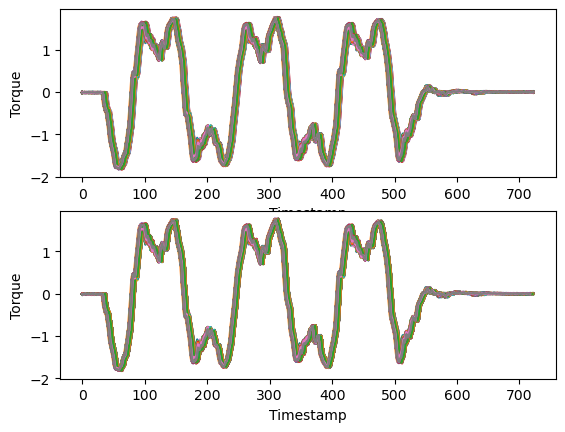

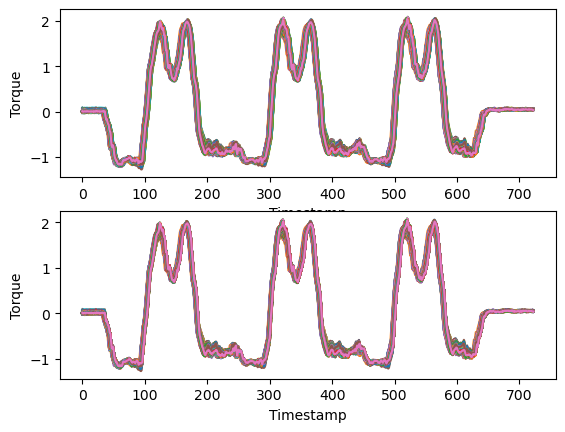

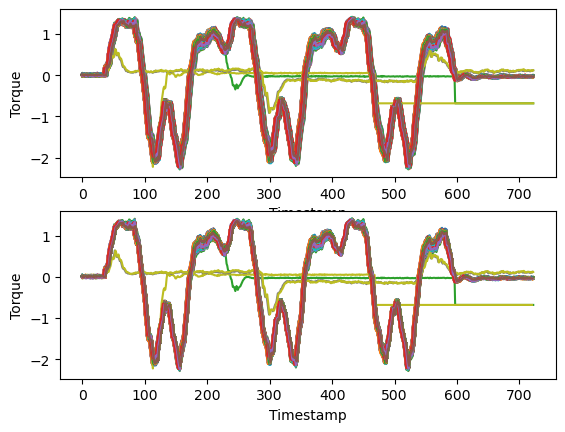

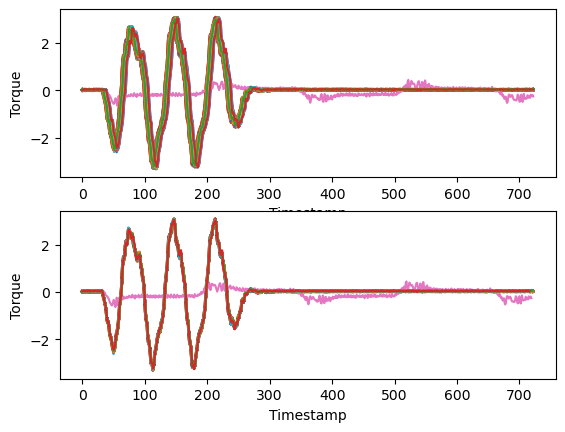

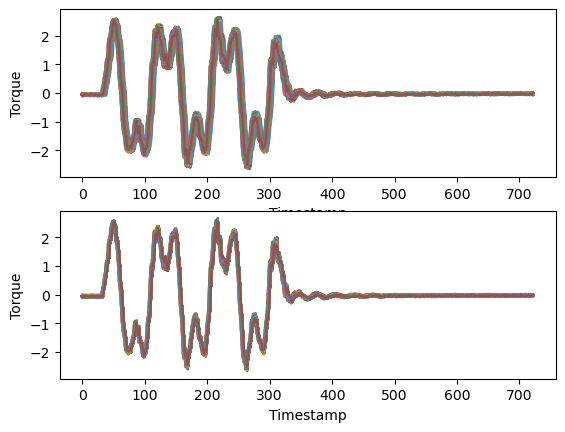

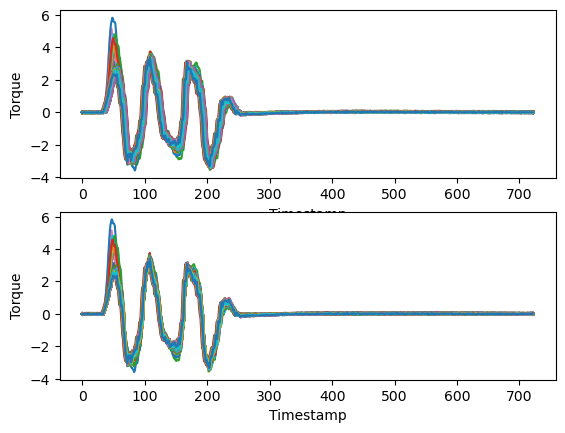

In [25]:
#Failure Case 2
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC2_7142240_66-51134/MCCFiles'
RMS_Value_FC2,Stv_FC2,Impulse_factor_FC2,Shape_factor_FC2 = generate_feature(File_path)


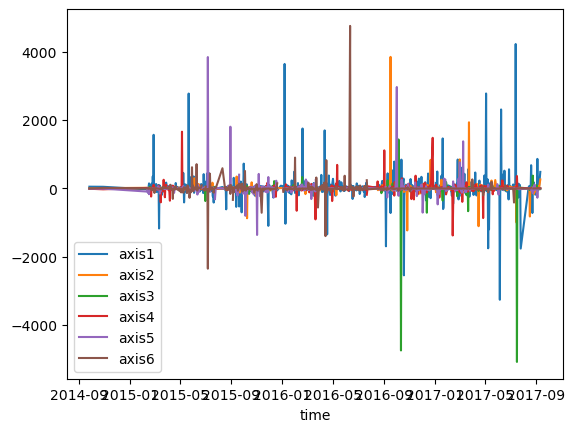

In [85]:
Shape_factor_FC2 = Shape_factor_FC2.groupby(by='time').mean()
Impulse_factor_FC2 = Impulse_factor_FC2.groupby(by='time').mean()
Shape_factor_FC2.plot()
fig.tight_layout()

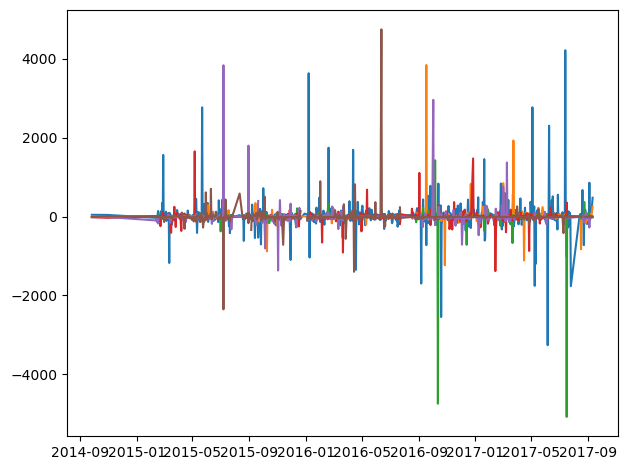

In [87]:
fig,ax = plt.subplots()

ax.plot(Shape_factor_FC2)
fig.tight_layout()

In [41]:
RMS_Value_FC2 = RMS_Value_FC2.groupby(by='time').mean()
Stv_FC2 = Stv_FC2.groupby(by='time').mean()

In [31]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()


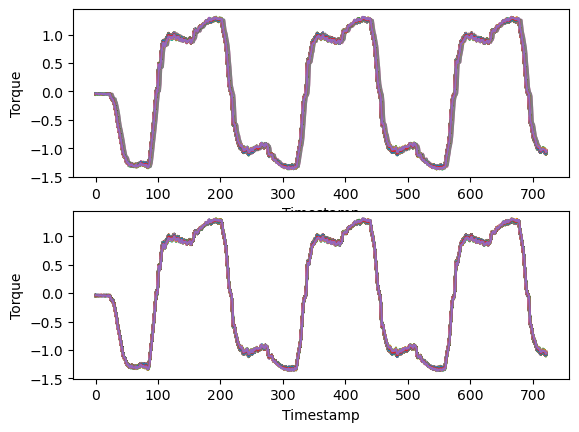

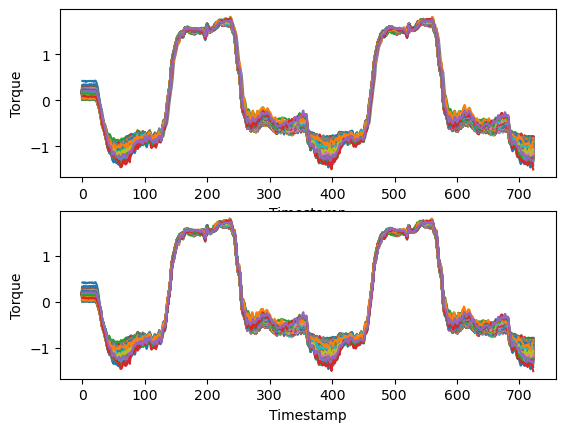

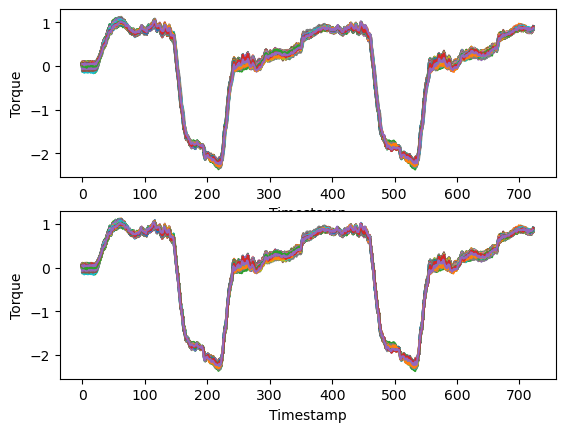

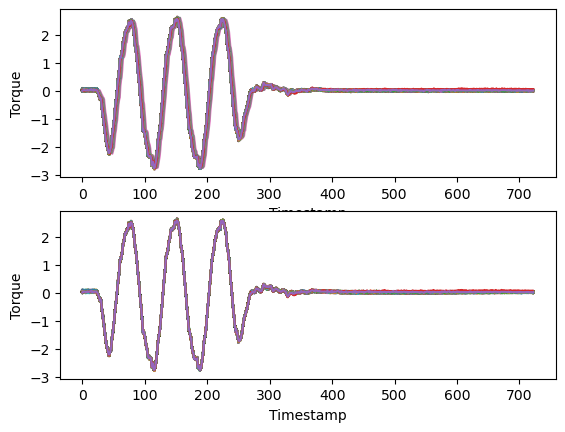

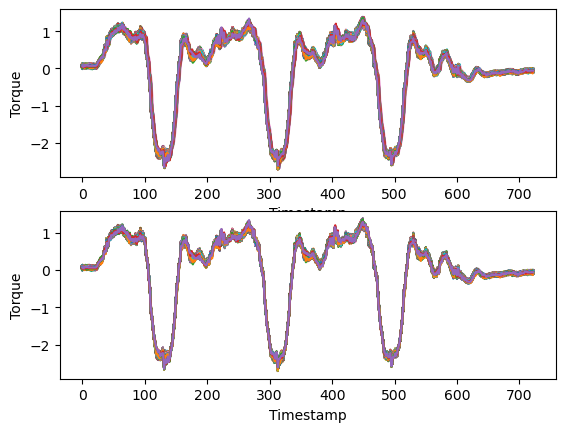

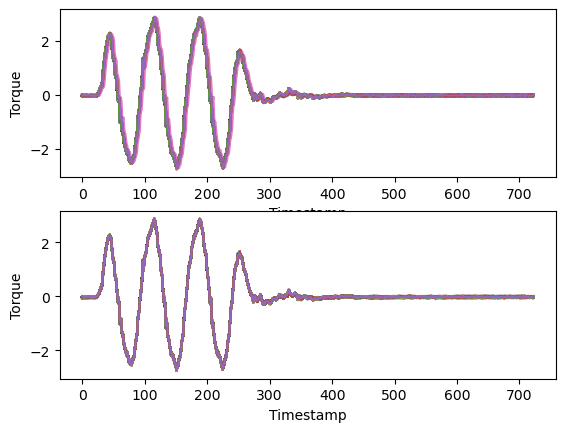

In [34]:
#Failure Case 10
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139/MCC Flies'
RMS_Value_FC10,Stv_FC10,Impulse_factor_FC10,Shape_factor_FC10  = generate_feature(File_path)

<AxesSubplot:>

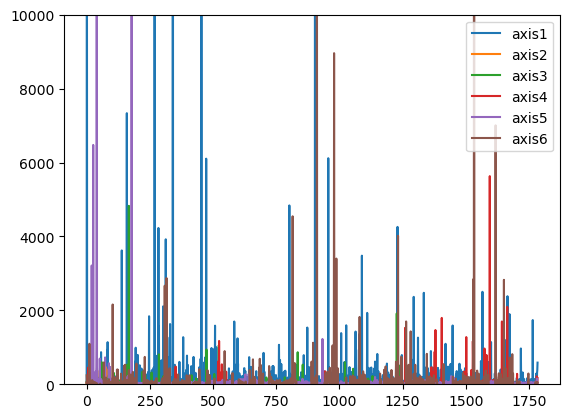

In [39]:
Impulse_factor_FC10.plot(ylim=[0, 10000])

In [42]:
RMS_Value_FC10 = RMS_Value_FC10.groupby(by='time').mean()
Stv_FC10 = Stv_FC10.groupby(by='time').mean()

In [45]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/1426-0051-56_DIAGDATA_20151016_090000__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

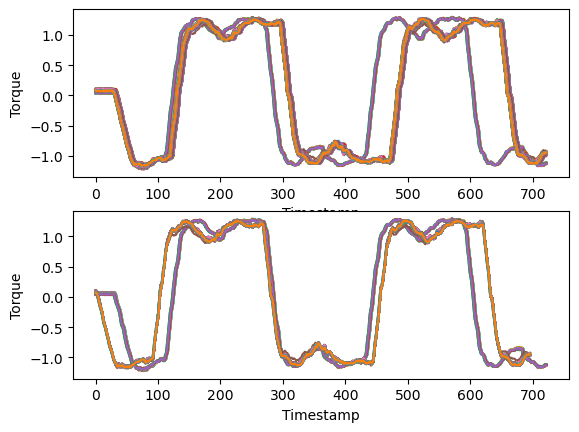

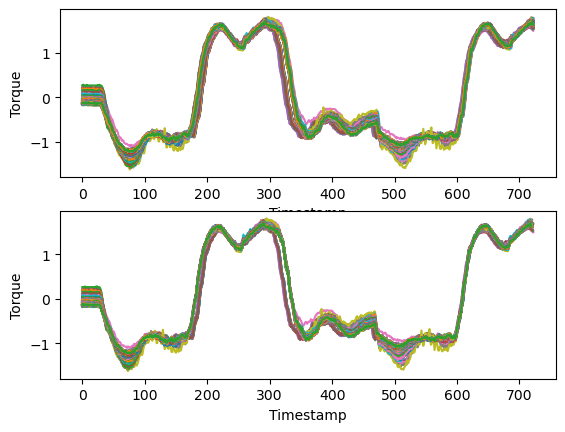

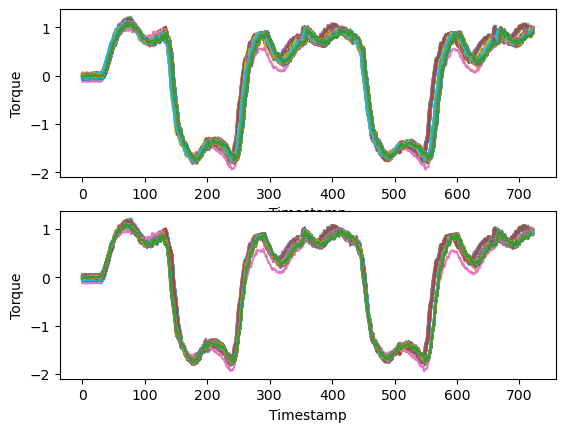

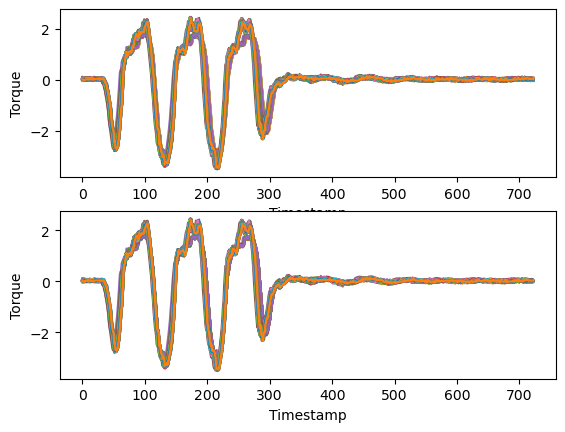

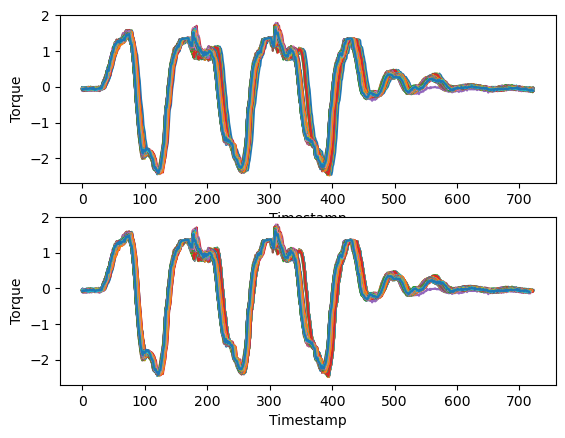

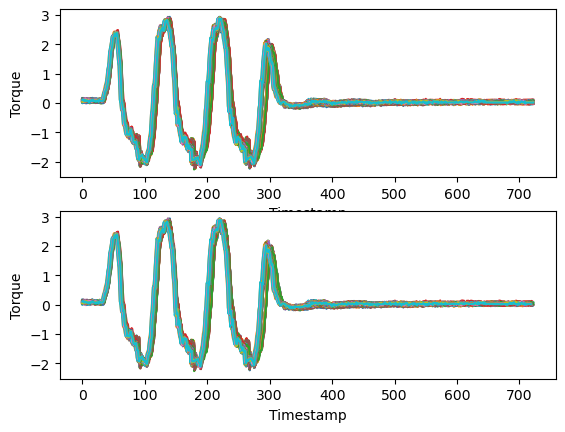

In [58]:
#Failure Case 1
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC1_113727087_6700-101962/MCCFiles'
RMS_Value_FC1,Stv_FC1,Impulse_factor_FC1,Shape_factor_FC1 = generate_feature(File_path)


In [60]:
RMS_Value_FC1 = RMS_Value_FC1.groupby(by='time').mean()
Stv_FC1 = Stv_FC1.groupby(by='time').mean()

<AxesSubplot:xlabel='time'>

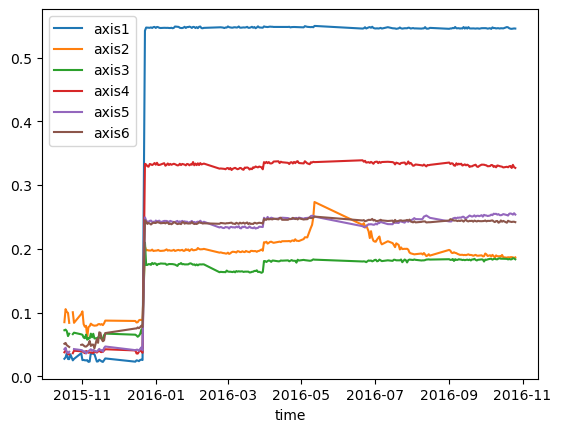

In [62]:
len(Stv_FC1)
test = RMS_Value_FC1
RMS_Value_FC1.plot()

In [59]:
Stv_FC1[30:90]

axis1     axis2     axis3     axis4     axis5     axis6        time
30  0.028162    0.0687  0.051421  0.042557  0.037704  0.050911  2015-11-20
31  0.023068  0.067809  0.051331  0.040553  0.033334  0.074837  2015-12-15
32    0.0252  0.067439  0.051462  0.035953  0.034615  0.075034  2015-12-16
33   0.02477  0.066683  0.048725  0.035558  0.034174  0.076809  2015-12-17
34  0.023884  0.068544  0.050441  0.038721  0.032523  0.075534  2015-12-18
35  0.025806  0.068403  0.052511  0.040529   0.03559  0.077122  2015-12-19
36  0.026244  0.068152  0.058202  0.039273  0.037135  0.079018  2015-12-20
37  0.025655  0.068602  0.052742  0.036937  0.034068   0.07733  2015-12-21
38  0.539991  0.183034  0.177435  0.330495  0.243786  0.231798  2015-12-23
39  0.544772   0.19705  0.171878  0.331908  0.244392  0.236194  2015-12-24
40  0.544613  0.197321  0.172067  0.329231  0.242461  0.234913  2015-12-25
41  0.544346  0.196865  0.173579  0.328362   0.24268  0.236431  2015-12-26
42  0.544328    0.1967    0.1736  0.332698  0.243962  0.235767  2015-12-27
43  0.544945  0.196772  0.172567  0.332043  0.244368  0.233056  2015-12-28
44  0.544085  0.198143  0.175588  0.330953  0.242098  0.236087  2015-12-29
45  0.545371  0.196211  0.173935  0.332206  0.242705  0.234971  2015-12-30
46  0.545756  0.196326  0.174942  0.334236  0.241616  0.237899  2015-12-31
47  0.544153  0.196551  0.174361  0.331408  0.244406  0.234111  2016-01-01
48  0.545705  0.196679  0.172611  0.334541  0.243303  0.238573  2016-01-02
49  0.545212  0.197778  0.174554  0.331043  0.243796  0.237429  2016-01-03
50  0.544275  0.196527  0.174507  0.331271  0.244187  0.236674  2016-01-04
51  0.544031  0.196071  0.174867  0.331755  0.241849  0.236303  2016-01-05
52  0.544285  0.196536  0.174438  0.333762  0.243836  0.236102  2016-01-08
53  0.544207  0.197629  0.174742  0.329274  0.243862  0.237038  2016-01-09
54  0.544181  0.198893  0.172977  0.330531  0.243784  0.238735  2016-01-10
55  0.544198   0.19689  0.173635  0.332741  0.243052  0.238055  2016-01-11
56  0.544028  0.197507  0.174031  0.330246  0.241851  0.235843  2016-01-12
57  0.543967   0.19664  0.173946   0.33213  0.243916  0.235466  2016-01-13
58  0.544266  0.196391  0.173729  0.330611  0.243122  0.235557  2016-01-14
59  0.543591  0.196906  0.173615  0.331374  0.242359   0.23524  2016-01-15
60  0.544247  0.197914  0.173325  0.332249  0.242194  0.239268  2016-01-16
61   0.54636  0.196131  0.173085  0.331727  0.242129  0.238005  2016-01-17
62  0.545876  0.197567  0.171344  0.329807  0.243844   0.23568  2016-01-19
63   0.54575  0.197772  0.173837  0.329817  0.241369  0.236266  2016-01-20
64  0.544359  0.197009   0.17383  0.332349  0.243111  0.235979  2016-01-21
65  0.543976   0.19751   0.17538  0.330229   0.24215  0.235443  2016-01-22
66  0.543932  0.198005   0.17369  0.331923  0.243919  0.238337  2016-01-23
67  0.544557  0.196462  0.174205  0.331487  0.242607  0.239204  2016-01-24
68  0.545869  0.196531  0.173518  0.331032  0.243188  0.236176  2016-01-25
69  0.544047  0.199034  0.173221  0.330217  0.242428  0.235544  2016-01-26
70  0.545525  0.197531  0.173693  0.332359  0.242683  0.235524  2016-01-27
71  0.545452  0.198329  0.173198  0.331896  0.240398  0.235905  2016-01-28
72  0.546177  0.195869  0.174551  0.330189   0.24185  0.235742  2016-01-29
73  0.545438  0.198121  0.175013  0.331808  0.242376  0.235828  2016-01-30
74  0.544071  0.199244  0.174524  0.331189  0.243788  0.236814  2016-01-31
75  0.545784  0.197541  0.173158  0.335484  0.241045  0.236777  2016-02-01
76  0.545519  0.197337  0.173522  0.330439  0.242261  0.234564  2016-02-02
77  0.543972  0.197797  0.171229  0.333244  0.240602  0.235892  2016-02-03
78  0.545416  0.198161  0.173272  0.330463  0.242129  0.235648  2016-02-04
79  0.543741  0.200609  0.171723  0.333355  0.242699  0.235485  2016-02-05
80  0.545909  0.199333  0.173145  0.330576  0.242037  0.237336  2016-02-06
81  0.546318  0.198857  0.173784  0.333794  0.244185  0.237132  2016-02-07
82  0.543849  0.198929  0.173573

In [64]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC3_33958577_46-50029/0824-0007-56_DIAGDATA_20091123_190122_MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff
fff


fff
fff


ValueError: operands could not be broadcast together with shapes (121,) (721,) 

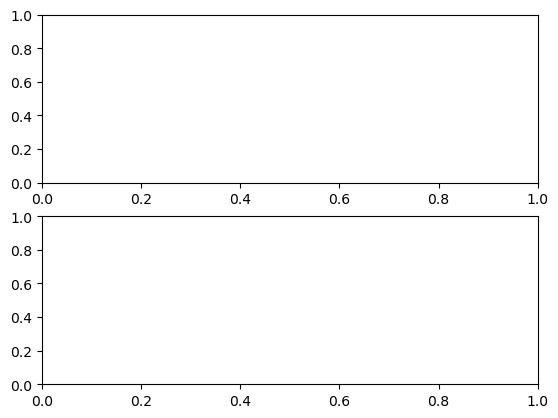

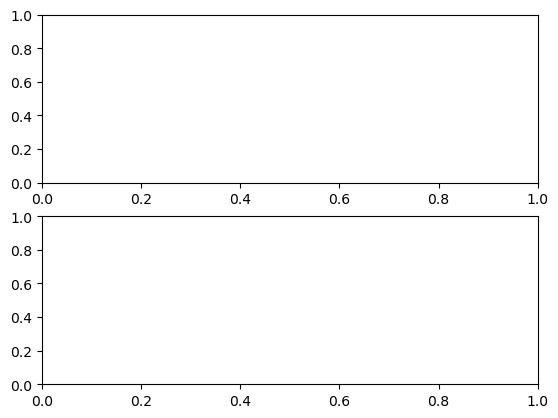

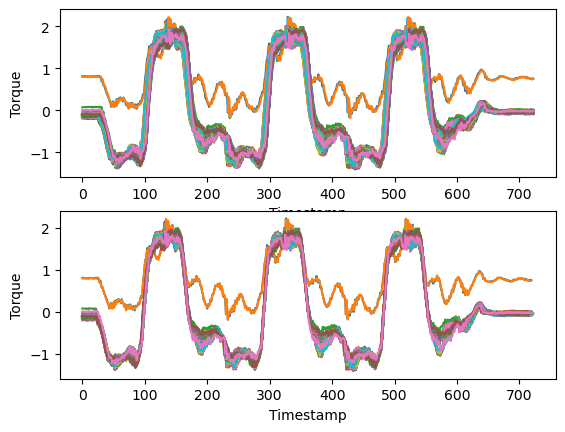

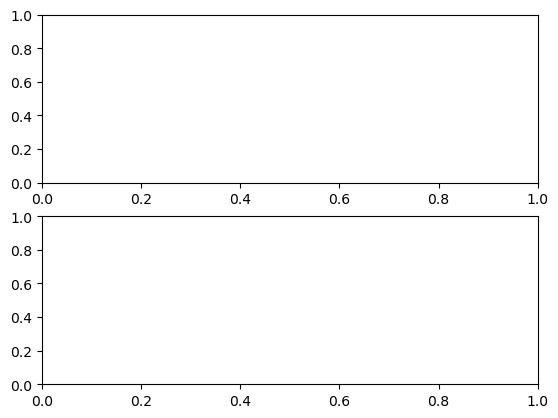

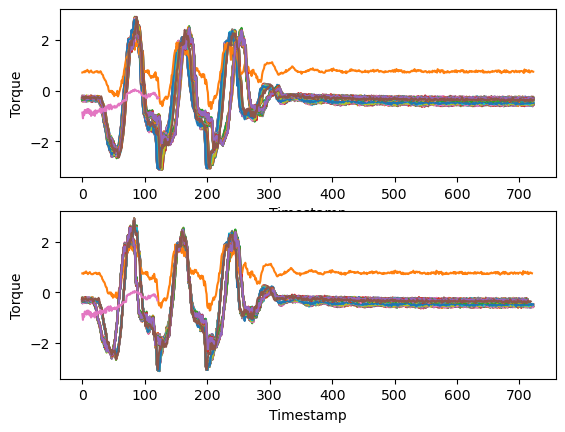

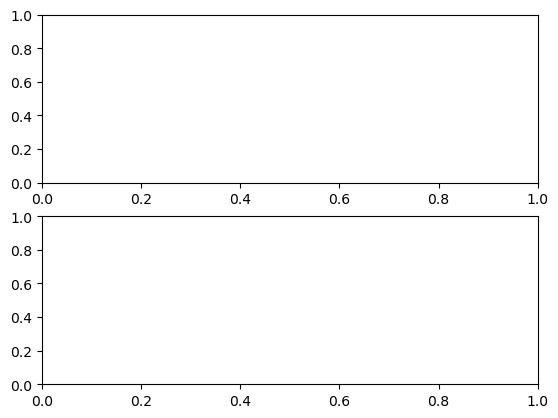

In [65]:
#Failure Case 3
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC3_33958577_46-50029/MCCFiles'
RMS_Value_FC3,Stv_FC3 = generate_feature(File_path)

In [68]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/1218-0079-56_DIAGDATA_20150410_142226__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()


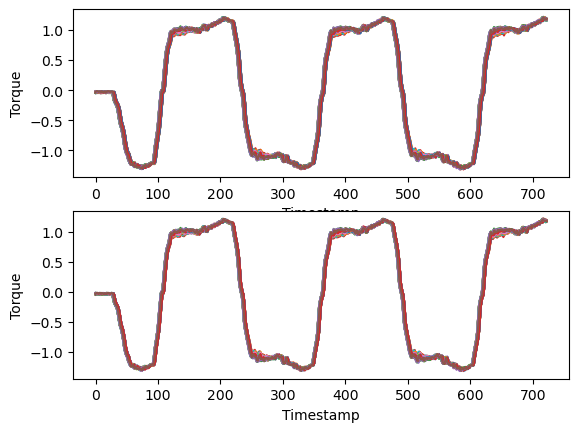

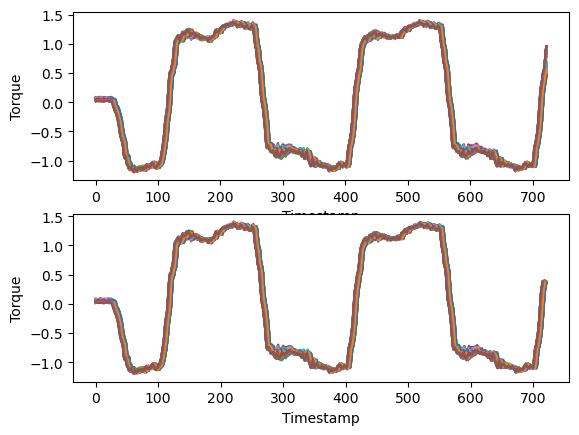

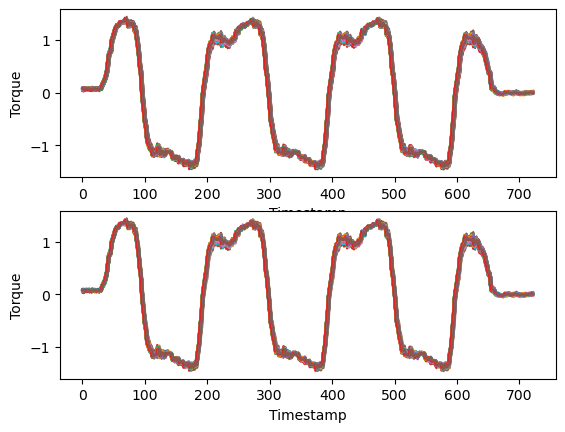

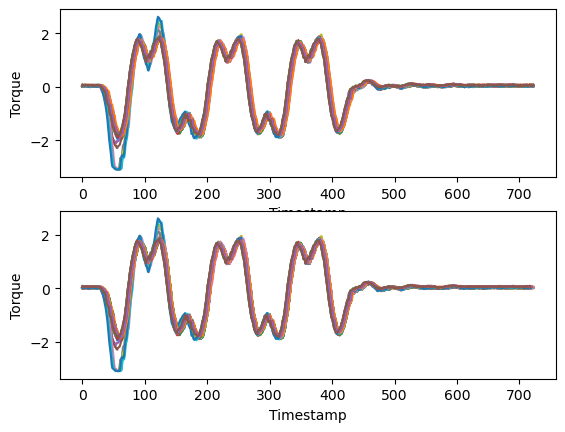

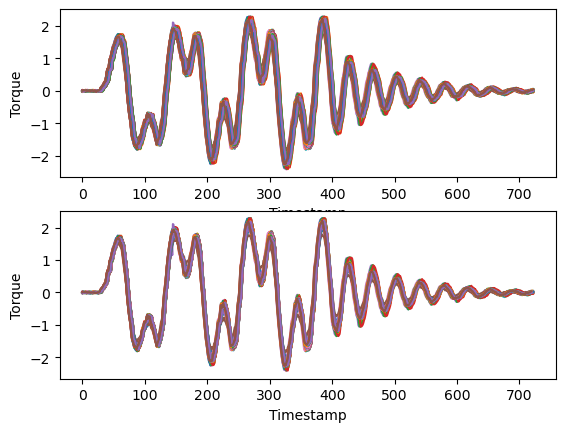

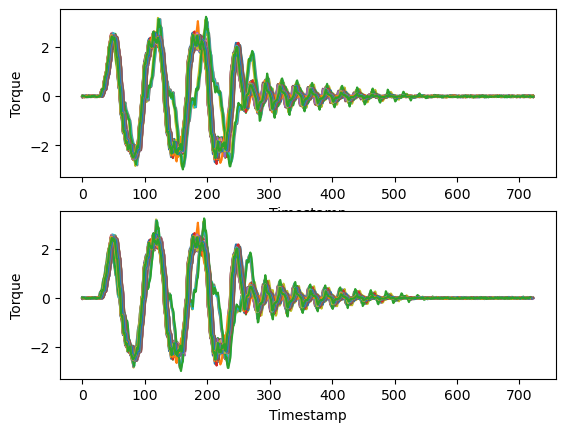

In [70]:
#Failure Case 6
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC6_33016615_66-62028/MCCFiles'
RMS_Value_FC6,Stv_FC6,Impulse_factor_FC6,Shape_factor_FC6 = generate_feature(File_path)

In [80]:

RMS_Value_FC6 = RMS_Value_FC6.dropna(axis=0,how='any')
RMS_Value_FC1 = RMS_Value_FC1.dropna(axis=0,how='any')

In [81]:
RMS_Value_FC6 = RMS_Value_FC6.groupby(by='time').mean()
Stv_FC6 = Stv_FC6.groupby(by='time').mean()

In [82]:
Stv_FC6 = Stv_FC6.dropna(axis=0,how='any')
Stv_FC1 = Stv_FC1.dropna(axis=0,how='any')

In [71]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/7600-102993_DIAGDATA_20160331_050019__MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

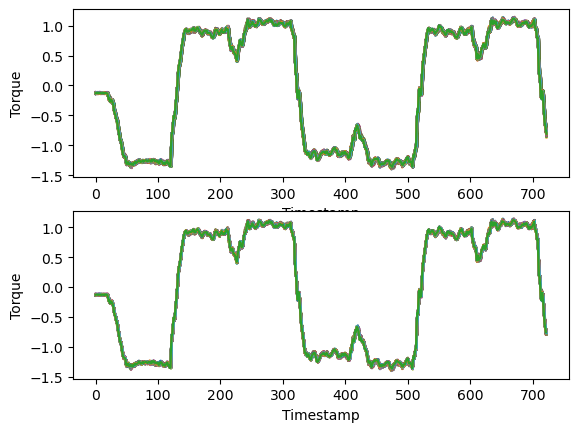

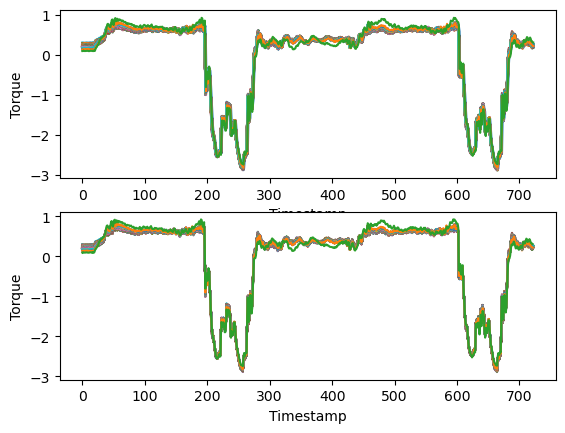

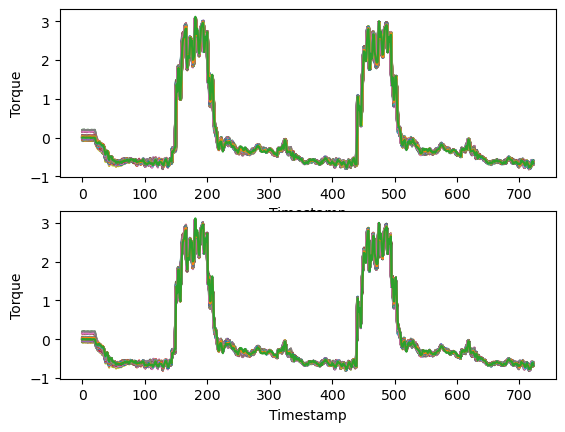

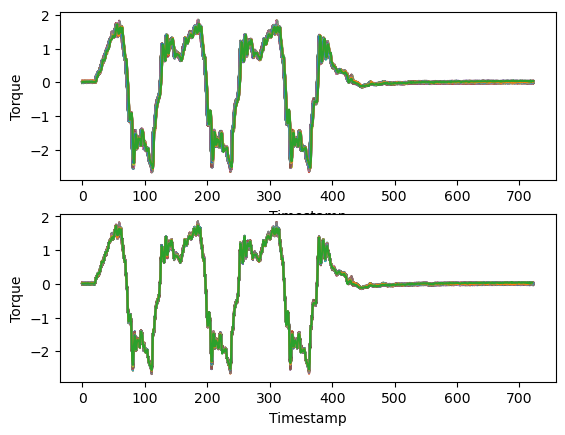

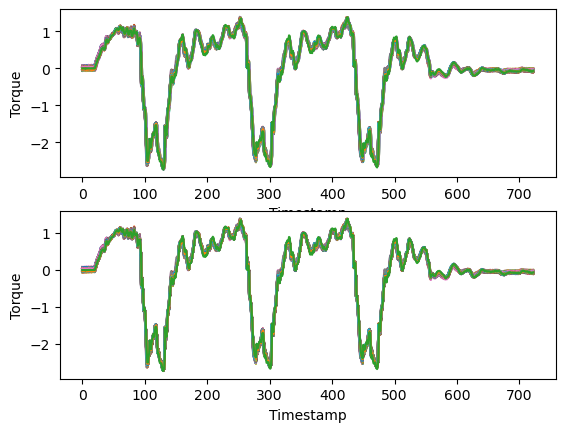

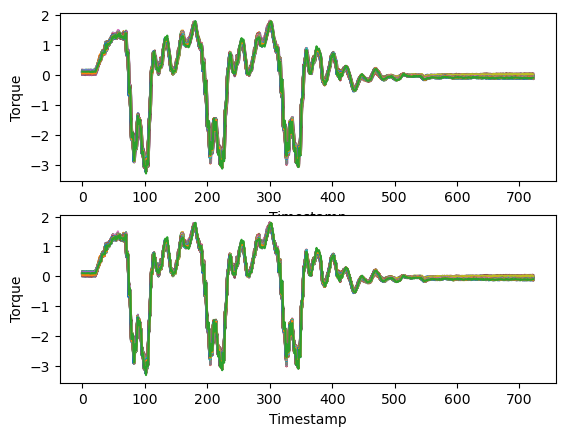

In [73]:
#Failure Case 7
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC7_130270916_7600-102993/MCCFiles'
RMS_Value_FC7,Stv_FC7, Impulse_factor_FC7,Shape_factor_FC7 = generate_feature(File_path)

In [74]:
RMS_Value_FC7 = RMS_Value_FC7.groupby(by='time').mean()
Stv_FC7 = Stv_FC7.groupby(by='time').mean()

In [75]:
file_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/1237-0041-56_DIAGDATA_20141107_131229_1a2edf8e-8453-4210-8f9d-4bbc65e75273_MCC.zip'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
with ZipFile(file_path) as File:
    for file in File.namelist():
        with File.open(file) as f:
            header = read_header(f)
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            if ax1 in file:
                ref1,mean1,stv1 = series.find_reference_point()
            elif ax2 in file:
                ref2,mean2,stv2 = series.find_reference_point()                  
            elif ax3 in file:
                ref3,mean3,stv3 = series.find_reference_point()
            elif ax4 in file:
                ref4,mean4,stv4 = series.find_reference_point()
            elif ax5 in file:
                ref5,mean5,stv5 = series.find_reference_point()
            elif ax6 in file:
                ref6,mean6,stv6 = series.find_reference_point()

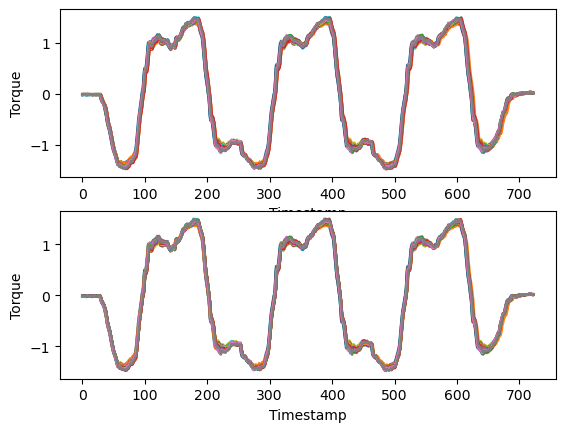

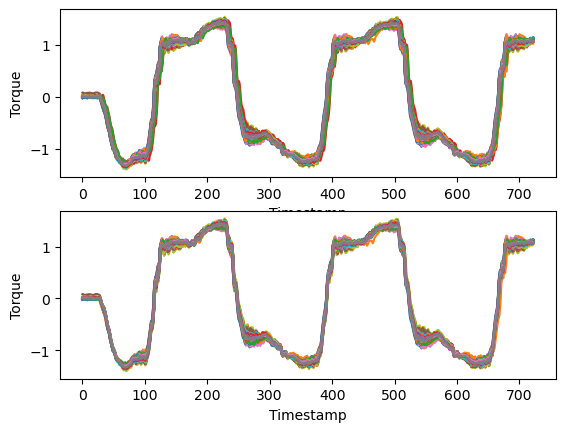

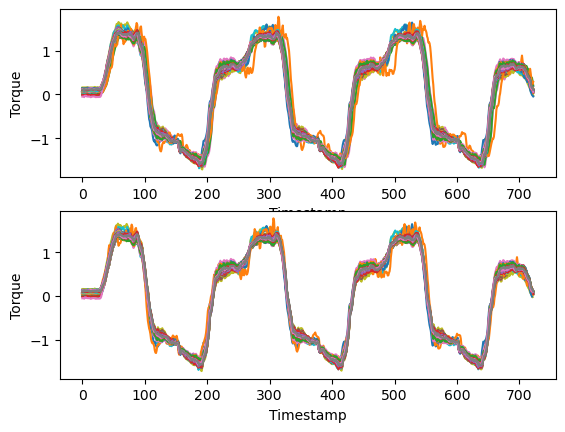

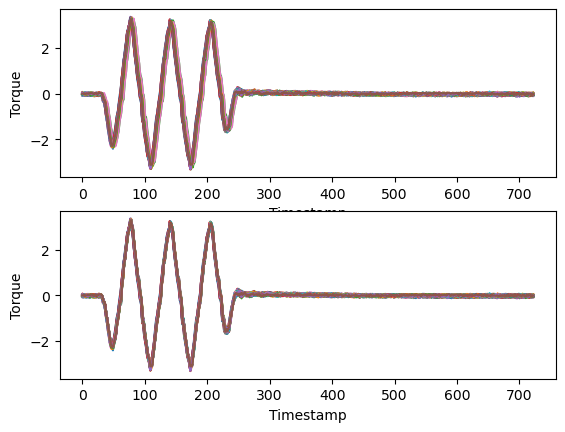

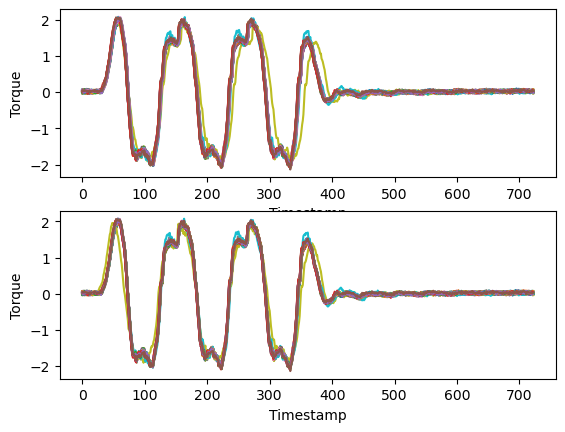

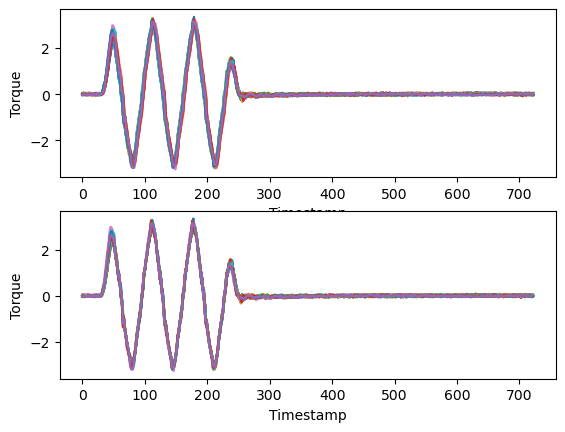

In [77]:
#Failure Case 8
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC8_103507723_6700-100888/MCCFiles'
RMS_Value_FC8,Stv_FC8,Impulse_factor_FC8,Shape_factor_FC8 = generate_feature(File_path)

In [168]:
Stv_FC8

axis1     axis2     axis3     axis4     axis5     axis6
time                                                                  
2014-11-07  0.007963  0.013283  0.015438  0.034323  0.024428  0.028427
2014-11-15  0.009182  0.019472  0.020660  0.036040  0.027587  0.027690
2014-11-28  0.008496  0.015525  0.024058  0.033992  0.029218  0.027735
2014-12-13  0.018304  0.025556  0.051219  0.038548  0.028956  0.050254
2015-01-10  0.009446  0.015302  0.025325  0.037902  0.026476  0.030769
...              ...       ...       ...       ...       ...       ...
2017-11-04  0.043463  0.049127  0.081714  0.077242  0.040548  0.135773
2017-11-11  0.034324  0.042359  0.057838  0.069211  0.038089  0.107320
2017-12-23  0.031314  0.045885  0.050157  0.065658  0.039555  0.097851
2018-01-13  0.031299  0.053439  0.047832  0.066517  0.037918  0.096041
2018-02-01  0.033786  0.047908  0.055279  0.063213  0.045236  0.106086

[68 rows x 6 columns]

In [78]:
RMS_Value_FC8 = RMS_Value_FC8.groupby(by='time').mean()
Stv_FC8 = Stv_FC8.groupby(by='time').mean()

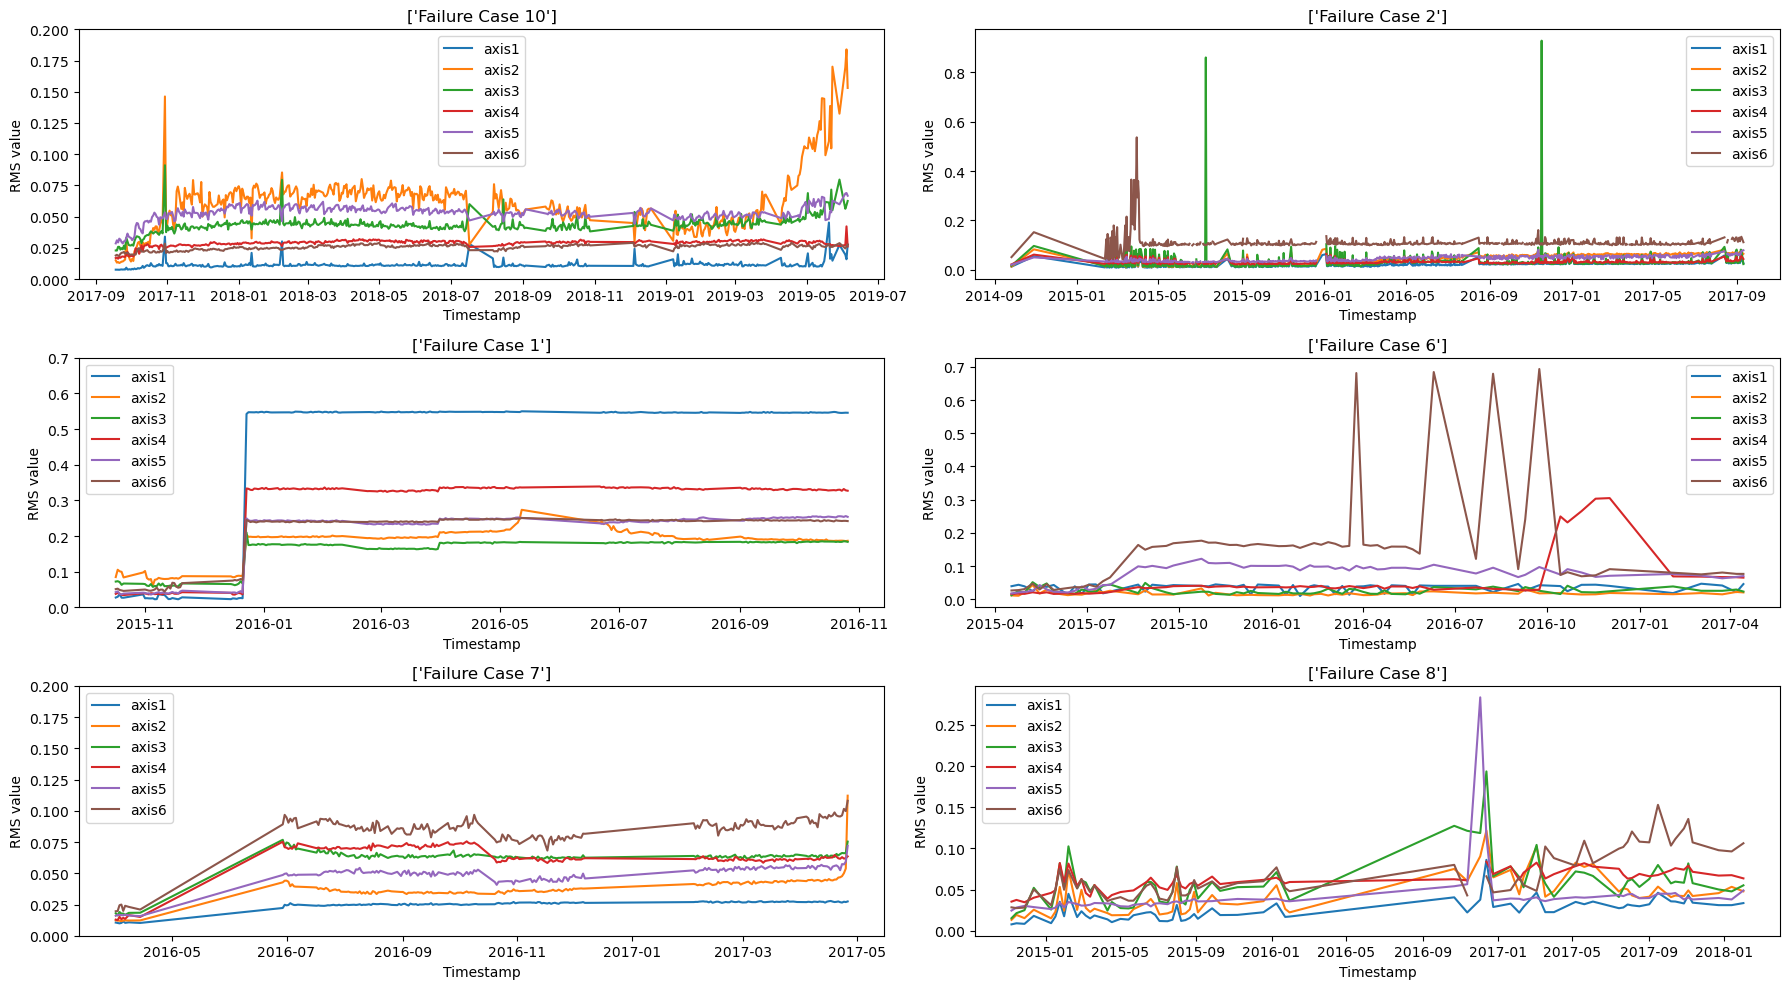

In [83]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig = plt.figure(figsize=(18,10))  
ax1 = fig.add_subplot(321)  
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)  
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)  
ax6 = fig.add_subplot(326)

for index in axis_list:

    ax1.plot(RMS_Value_FC10[index], label= index)
    ax1.set_title(['Failure Case 10'])  
    ax1.set_xlabel('Timestamp')  
    ax1.set_ylabel('RMS value')
    ax1.set_ylim(0, .2)
    ax1.legend()
    
    ax2.plot(RMS_Value_FC2[index], label= index)
    ax2.set_title(['Failure Case 2'])  
    ax2.set_xlabel('Timestamp')  
    ax2.set_ylabel('RMS value')
#     ax2.set_ylim(0, .2)
    ax2.legend()

    
    ax3.plot(RMS_Value_FC1[index], label= index)
    ax3.set_title(['Failure Case 1'])  
    ax3.set_xlabel('Timestamp')  
    ax3.set_ylabel('RMS value')
    ax3.set_ylim(0, .7)
    ax3.legend()
    
    ax4.plot(RMS_Value_FC6[index], label= index)
    ax4.set_title(['Failure Case 6'])  
    ax4.set_xlabel('Timestamp')  
    ax4.set_ylabel('RMS value')
#     ax4.set_ylim(0, .2)
    ax4.legend() 
    
    
    ax5.plot(RMS_Value_FC7[index], label= index)
    ax5.set_title(['Failure Case 7'])  
    ax5.set_xlabel('Timestamp')  
    ax5.set_ylabel('RMS value')
    ax5.set_ylim(0, .2)
    ax5.legend()
    
    ax6.plot(RMS_Value_FC8[index], label= index)
    ax6.set_title(['Failure Case 8'])  
    ax6.set_xlabel('Timestamp')  
    ax6.set_ylabel('RMS value')
#     ax6.set_ylim(0, .2)
    ax6.legend()
plt.tight_layout()

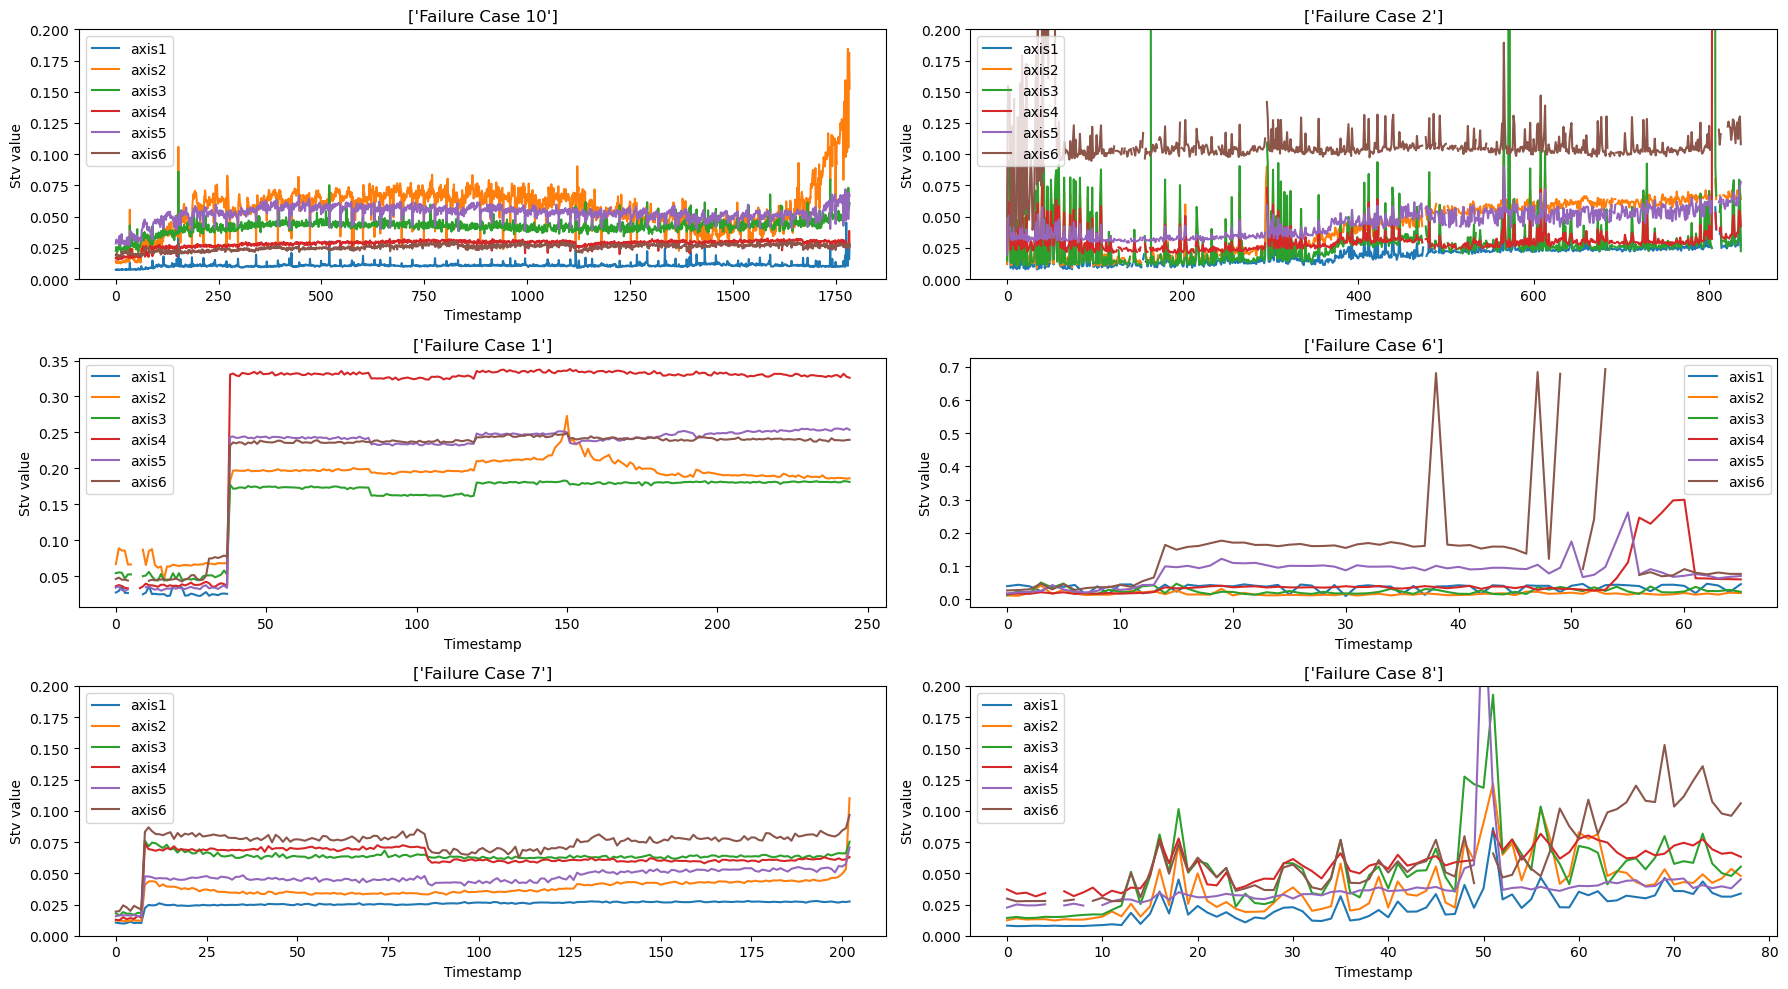

In [27]:
axis_list = ['axis1','axis2','axis3','axis4','axis5','axis6']
fig = plt.figure(figsize=(18,10))  
ax1 = fig.add_subplot(321)  
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)  
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)  
ax6 = fig.add_subplot(326)

for index in axis_list:

    ax1.plot(Stv_FC10[index], label= index)
    ax1.set_title(['Failure Case 10'])  
    ax1.set_xlabel('Timestamp')  
    ax1.set_ylabel('Stv value')
    ax1.set_ylim(0, .2)
    ax1.legend()
    
    ax2.plot(Stv_FC2[index], label= index)
    ax2.set_title(['Failure Case 2'])  
    ax2.set_xlabel('Timestamp')  
    ax2.set_ylabel('Stv value')
    ax2.set_ylim(0, .2)
    ax2.legend()

    
    ax3.plot(Stv_FC1[index], label= index)
    ax3.set_title(['Failure Case 1'])  
    ax3.set_xlabel('Timestamp')  
    ax3.set_ylabel('Stv value')
#     ax3.set_ylim(0, .2)
    ax3.legend()
    
    ax4.plot(Stv_FC6[index], label= index)
    ax4.set_title(['Failure Case 6'])  
    ax4.set_xlabel('Timestamp')  
    ax4.set_ylabel('Stv value')
#     ax4.set_ylim(0, .2)
    ax4.legend() 
    
    
    ax5.plot(Stv_FC7[index], label= index)
    ax5.set_title(['Failure Case 7'])  
    ax5.set_xlabel('Timestamp')  
    ax5.set_ylabel('Stv value')
    ax5.set_ylim(0, .2)
    ax5.legend()
    
    ax6.plot(Stv_FC8[index], label= index)
    ax6.set_title(['Failure Case 8'])  
    ax6.set_xlabel('Timestamp')  
    ax6.set_ylabel('Stv value')
    ax6.set_ylim(0, .2)
    ax6.legend()

plt.tight_layout()

# Features for each axis

In [88]:
feature_axis1_FC2 = pd.concat([RMS_Value_FC2['axis1'],Stv_FC2['axis1']],axis=1)
feature_axis1_FC2.columns = ['RMS','Stv']

feature_axis1_FC10 = pd.concat([RMS_Value_FC10['axis1'],Stv_FC10['axis1']],axis=1)
feature_axis1_FC10.columns = ['RMS','Stv']

<AxesSubplot:xlabel='timestamp'>

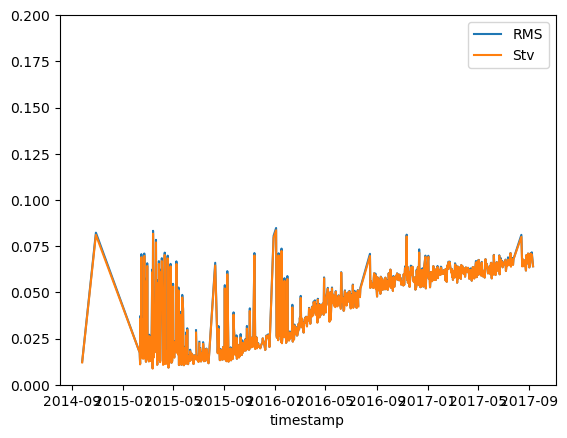

In [89]:
feature_axis2_FC2 = pd.concat([RMS_Value_FC2['axis2'],Stv_FC2['axis2']],axis=1)
feature_axis2_FC2.columns = ['RMS','Stv']

feature_axis2_FC10 = pd.concat([RMS_Value_FC10['axis2'],Stv_FC10['axis2']],axis=1)
feature_axis2_FC10.columns = ['RMS','Stv']

feature_axis2_FC2.plot(xlabel='timestamp',ylim=[0, 0.2])

In [90]:
feature_axis3_FC2 = pd.concat([RMS_Value_FC2['axis3'],Stv_FC2['axis3']],axis=1)
feature_axis3_FC2.columns = ['RMS','Stv']

feature_axis3_FC10 = pd.concat([RMS_Value_FC10['axis3'],Stv_FC10['axis3']],axis=1)
feature_axis3_FC10.columns = ['RMS','Stv']

In [91]:
feature_axis4_FC2 = pd.concat([RMS_Value_FC2['axis4'],Stv_FC2['axis4']],axis=1)
feature_axis4_FC2.columns = ['RMS','Stv']

feature_axis4_FC10 = pd.concat([RMS_Value_FC10['axis4'],Stv_FC10['axis4']],axis=1)
feature_axis4_FC10.columns = ['RMS','Stv']

In [92]:
feature_axis5_FC2 = pd.concat([RMS_Value_FC2['axis5'],Stv_FC2['axis5']],axis=1)
feature_axis5_FC2.columns = ['RMS','Stv']

feature_axis5_FC10 = pd.concat([RMS_Value_FC10['axis5'],Stv_FC10['axis5']],axis=1)
feature_axis5_FC10.columns = ['RMS','Stv']

In [93]:
feature_axis6_FC2 = pd.concat([RMS_Value_FC2['axis6'],Stv_FC2['axis6']],axis=1)
feature_axis6_FC2.columns = ['RMS','Stv']

feature_axis6_FC10 = pd.concat([RMS_Value_FC10['axis6'],Stv_FC10['axis6']],axis=1)
feature_axis6_FC10.columns = ['RMS','Stv']

In [169]:
feature_axis1_FC7 = pd.concat([RMS_Value_FC7['axis1'],Stv_FC7['axis1']],axis=1)
feature_axis1_FC7.columns = ['RMS','Stv']

feature_axis1_FC8 = pd.concat([RMS_Value_FC8['axis1'],Stv_FC8['axis1']],axis=1)
feature_axis1_FC8.columns = ['RMS','Stv']

feature_axis2_FC7 = pd.concat([RMS_Value_FC7['axis2'],Stv_FC7['axis2']],axis=1)
feature_axis2_FC7.columns = ['RMS','Stv']

feature_axis2_FC8 = pd.concat([RMS_Value_FC8['axis2'],Stv_FC8['axis2']],axis=1)
feature_axis2_FC8.columns = ['RMS','Stv']

feature_axis3_FC7 = pd.concat([RMS_Value_FC7['axis3'],Stv_FC7['axis3']],axis=1)
feature_axis3_FC7.columns = ['RMS','Stv']

feature_axis3_FC8 = pd.concat([RMS_Value_FC8['axis3'],Stv_FC8['axis3']],axis=1)
feature_axis3_FC8.columns = ['RMS','Stv']

feature_axis4_FC7 = pd.concat([RMS_Value_FC7['axis4'],Stv_FC7['axis4']],axis=1)
feature_axis4_FC7.columns = ['RMS','Stv']

feature_axis4_FC8 = pd.concat([RMS_Value_FC8['axis4'],Stv_FC8['axis4']],axis=1)
feature_axis4_FC8.columns = ['RMS','Stv']

feature_axis5_FC7 = pd.concat([RMS_Value_FC7['axis5'],Stv_FC7['axis5']],axis=1)
feature_axis5_FC7.columns = ['RMS','Stv']

feature_axis5_FC8 = pd.concat([RMS_Value_FC8['axis5'],Stv_FC8['axis5']],axis=1)
feature_axis5_FC8.columns = ['RMS','Stv']

feature_axis6_FC7 = pd.concat([RMS_Value_FC7['axis6'],Stv_FC7['axis6']],axis=1)
feature_axis6_FC7.columns = ['RMS','Stv']

feature_axis6_FC8 = pd.concat([RMS_Value_FC8['axis6'],Stv_FC8['axis6']],axis=1)
feature_axis6_FC8.columns = ['RMS','Stv']

# Clustering between two features (each axis) 

In [94]:
from sklearn.cluster import KMeans

In [102]:
index = pd.DatetimeIndex(pd.date_range('20170101', '20190101', freq='W'))
index

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2018-10-28', '2018-11-04', '2018-11-11', '2018-11-18',
               '2018-11-25', '2018-12-02', '2018-12-09', '2018-12-16',
               '2018-12-23', '2018-12-30'],
              dtype='datetime64[ns]', length=105, freq='W-SUN')

In [123]:
df = feature_axis1_FC2

In [124]:
df.index = pd.to_datetime(df.index)


C:\Temp\ipykernel_6300\4177633405.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


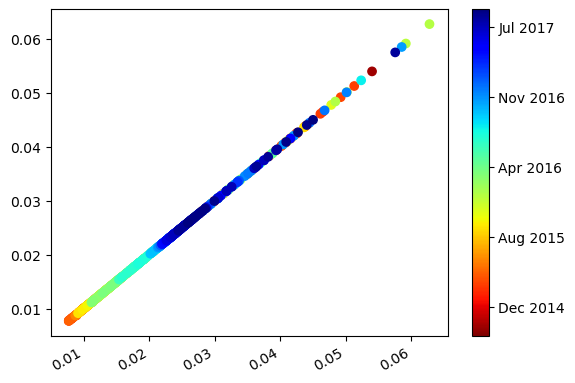

In [126]:
from datetime import datetime


fig,ax=plt.subplots()
sca = ax.scatter(df['RMS'], df['Stv'],c=df.index,cmap='jet_r')
cbar = plt.colorbar(sca)

cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))

fig.autofmt_xdate()
plt.show()

In [146]:
def plot_figure(df,FCname):
    p_cluster = df[0:20]
    kmeans = KMeans(n_clusters=1)
    kmeans.fit(p_cluster)


    centers = kmeans.cluster_centers_
    print(centers)
    
    fig,ax = plt.subplots()

    ax.set_ylim(0, .2)
    ax.set_xlim(0, .2)

    ax.set_xlabel('RMS')  
    ax.set_ylabel('Standard Deviation')
    ax.set_title(FCname) 
    
    df.index = pd.to_datetime(df.index)
    sca = ax.scatter(df['RMS'], df['Stv'],c=df.index,cmap='jet_r')
    cbar = plt.colorbar(sca)

    cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
    ax.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    fig.autofmt_xdate()
    plt.show()

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.02095908 0.02095278]]


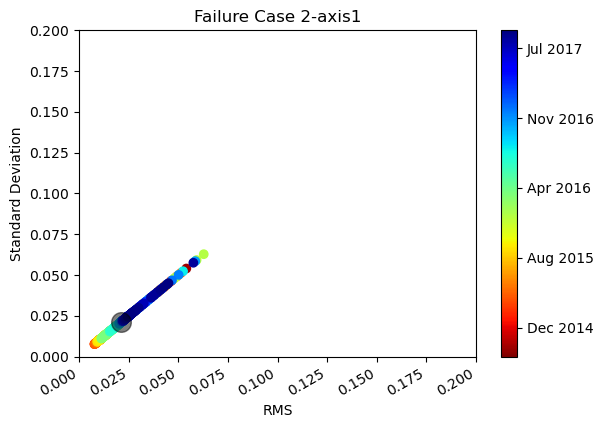

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.00786978 0.00786281]]


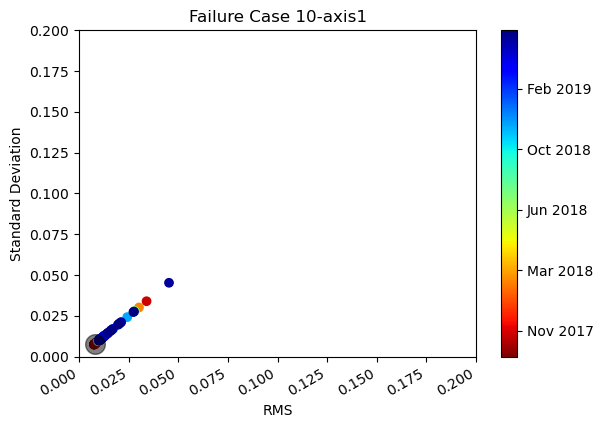

In [147]:
data1 = feature_axis1_FC2
data2 = feature_axis1_FC10
FCname1, FCname2 = 'Failure Case 2-axis1','Failure Case 10-axis1'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.01885817 0.01875797]]


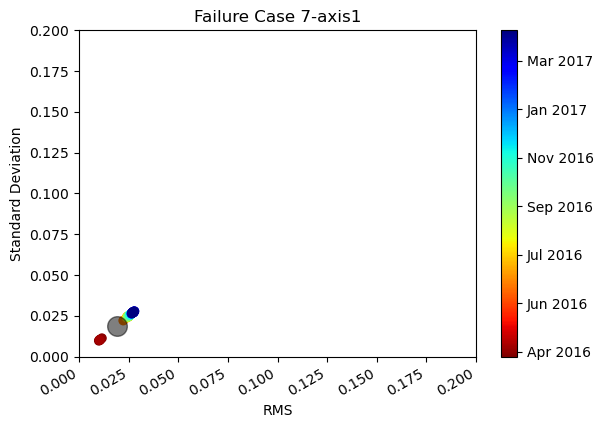

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.01788104 0.01785754]]


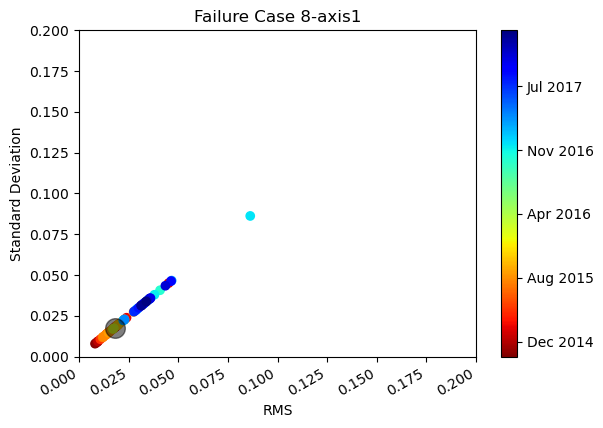

In [154]:
data1 = feature_axis1_FC7
data2 = feature_axis1_FC8
FCname1, FCname2 = 'Failure Case 7-axis1','Failure Case 8-axis1'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.0309789  0.03019577]]


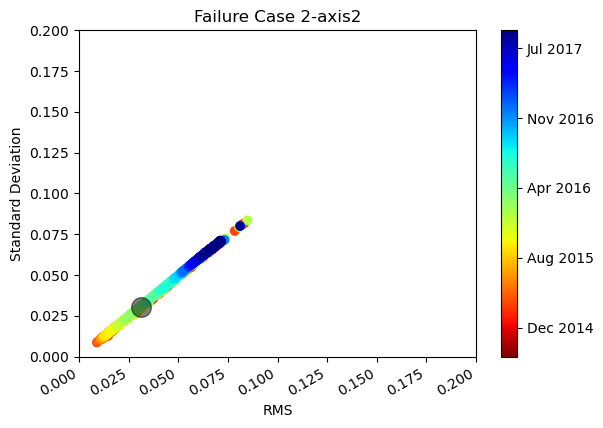

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[0.01787356 0.01732443]]


C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


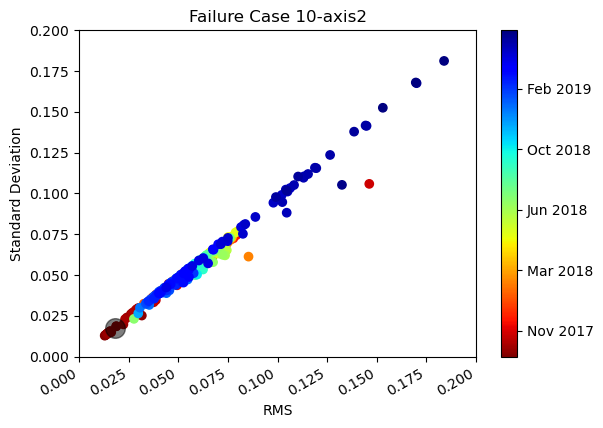

In [148]:
data1 = feature_axis2_FC2
data2 = feature_axis2_FC10
FCname1, FCname2 = 'Failure Case 2-axis2','Failure Case 10-axis2'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.02921375 0.0289995 ]]


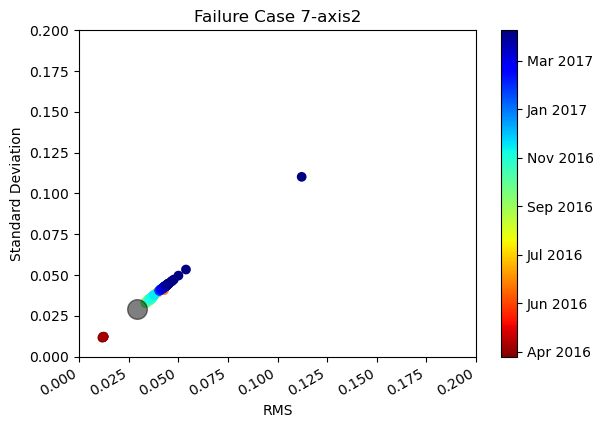

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.02792816 0.02785057]]


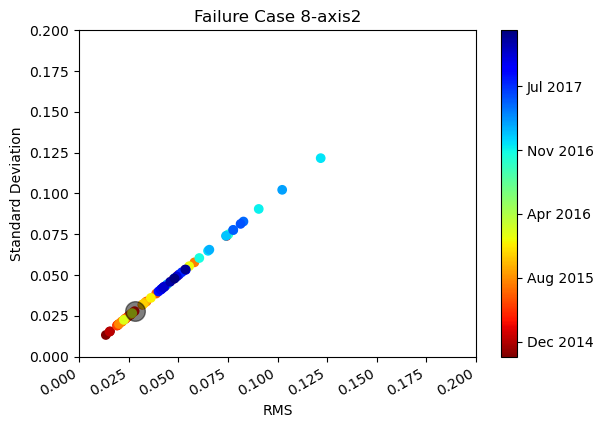

In [155]:
data1 = feature_axis2_FC7
data2 = feature_axis2_FC8
FCname1, FCname2 = 'Failure Case 7-axis2','Failure Case 8-axis2'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.03549271 0.03421696]]


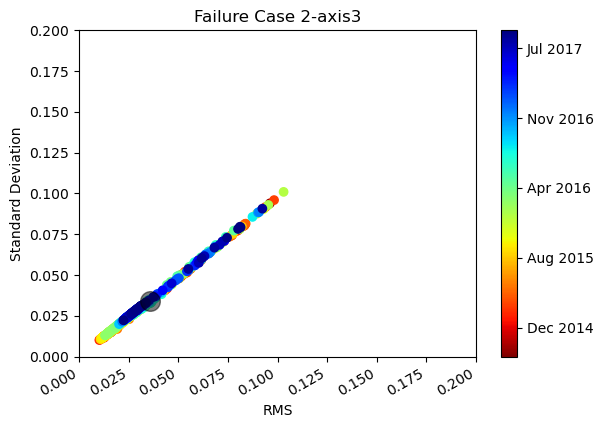

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.02752112 0.02736176]]


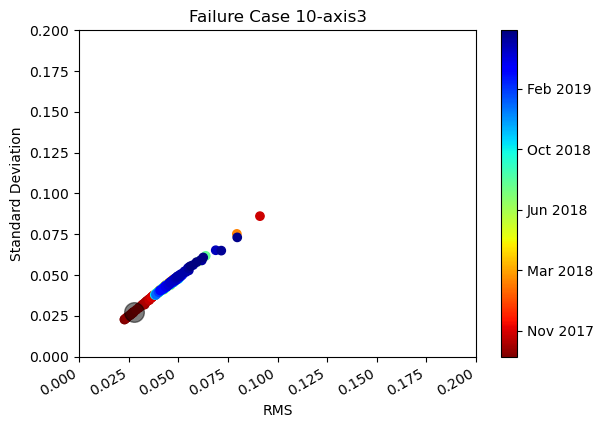

In [149]:
data1 = feature_axis3_FC2
data2 = feature_axis3_FC10
FCname1, FCname2 = 'Failure Case 2-axis3','Failure Case 10-axis3'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.04982703 0.04975694]]


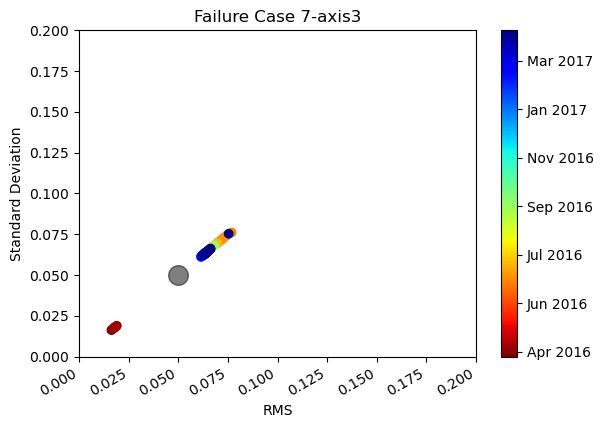

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.0451773 0.0440204]]


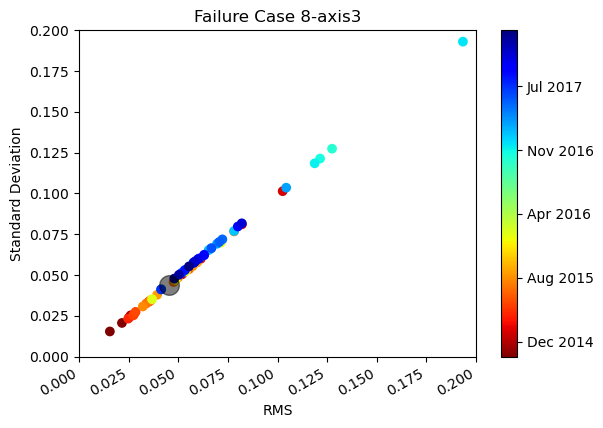

In [156]:
data1 = feature_axis3_FC7
data2 = feature_axis3_FC8
FCname1, FCname2 = 'Failure Case 7-axis3','Failure Case 8-axis3'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.03521091 0.03498058]]


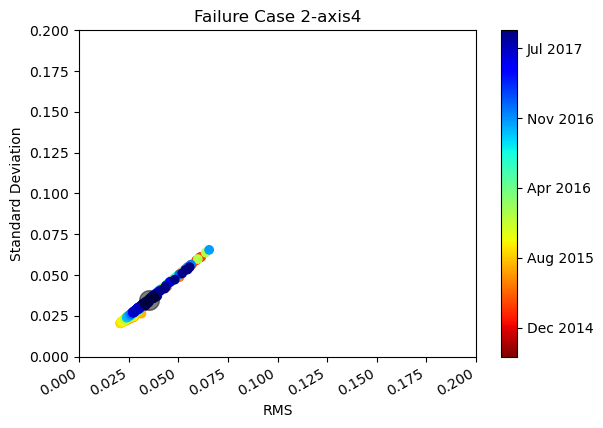

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[0.01898881 0.01878258]]


C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


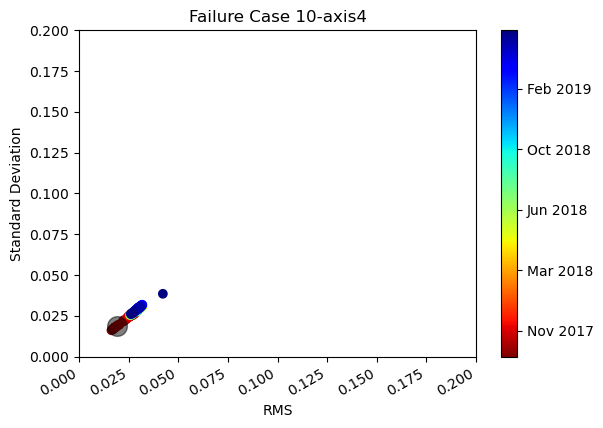

In [150]:
data1 = feature_axis4_FC2
data2 = feature_axis4_FC10
FCname1, FCname2 = 'Failure Case 2-axis4','Failure Case 10-axis4'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.04830878 0.04732623]]


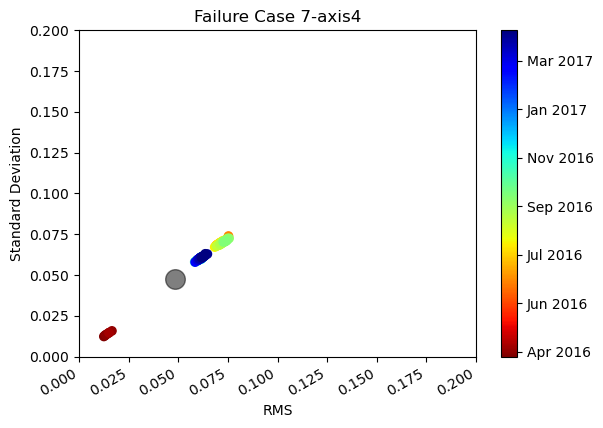

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.05073647 0.04779518]]


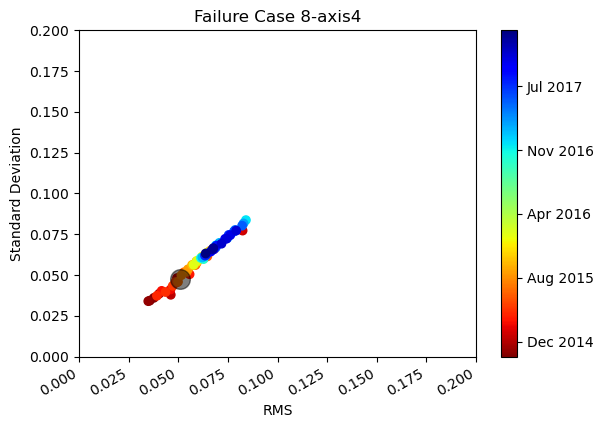

In [157]:
data1 = feature_axis4_FC7
data2 = feature_axis4_FC8
FCname1, FCname2 = 'Failure Case 7-axis4','Failure Case 8-axis4'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.03469318 0.03443436]]


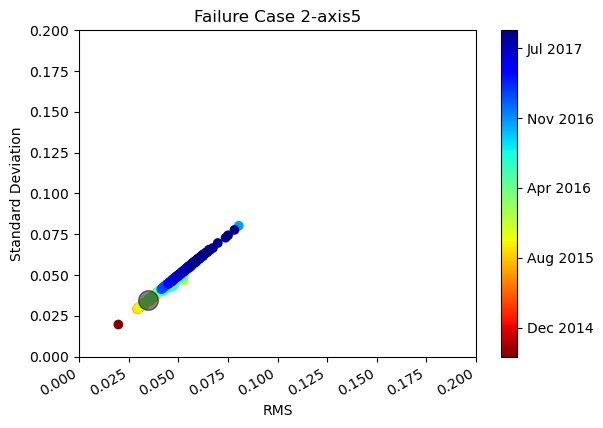

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.03353245 0.03341758]]


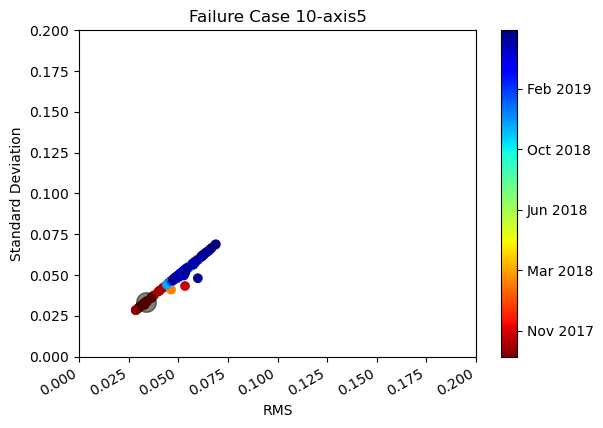

In [151]:
data1 = feature_axis5_FC2
data2 = feature_axis5_FC10
FCname1, FCname2 = 'Failure Case 2-axis5','Failure Case 10-axis5'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.03582099 0.03397689]]


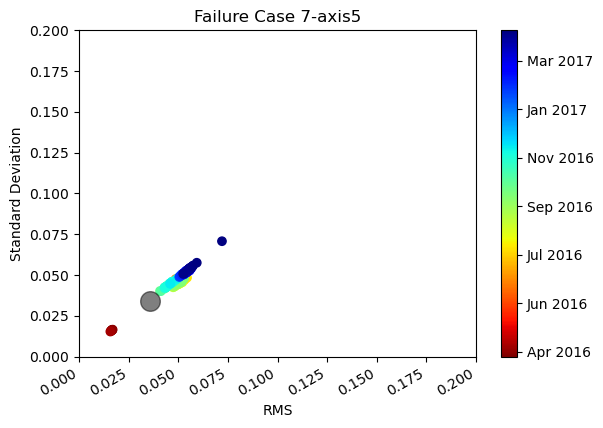

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.03082014 0.03052533]]


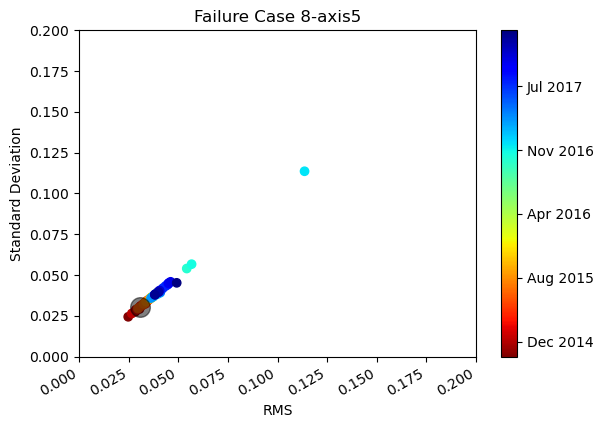

In [170]:
data1 = feature_axis5_FC7
data2 = feature_axis5_FC8
FCname1, FCname2 = 'Failure Case 7-axis5','Failure Case 8-axis5'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.09247772 0.09158993]]


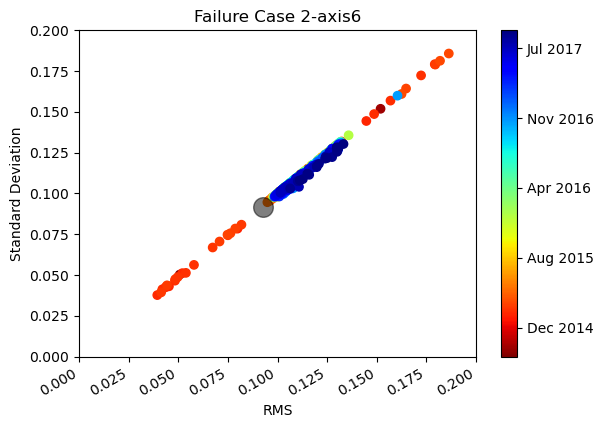

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.02031339 0.02020961]]


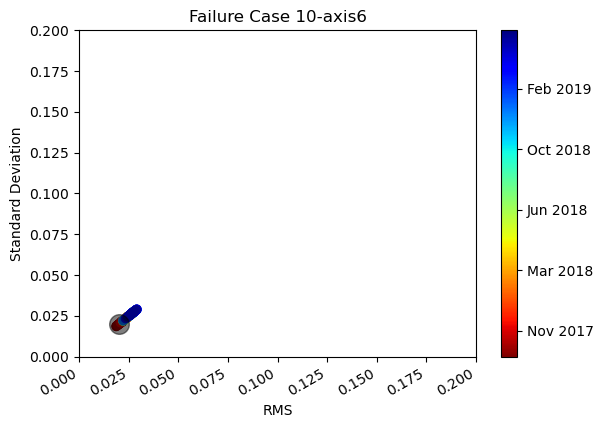

In [152]:
data1 = feature_axis6_FC2
data2 = feature_axis6_FC10
FCname1, FCname2 = 'Failure Case 2-axis6','Failure Case 10-axis6'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.06406988 0.05777759]]


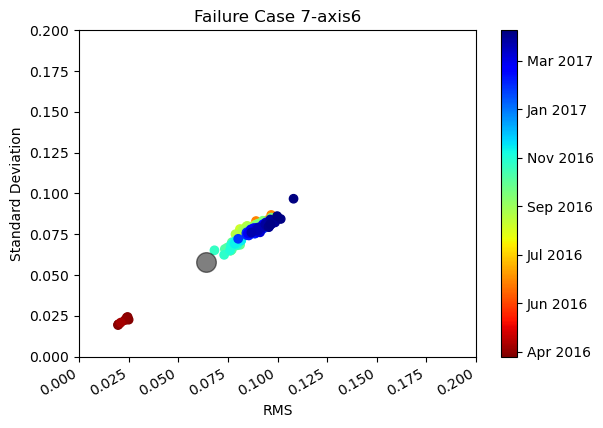

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Temp\ipykernel_6300\578212465.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))


[[0.04657119 0.04630288]]


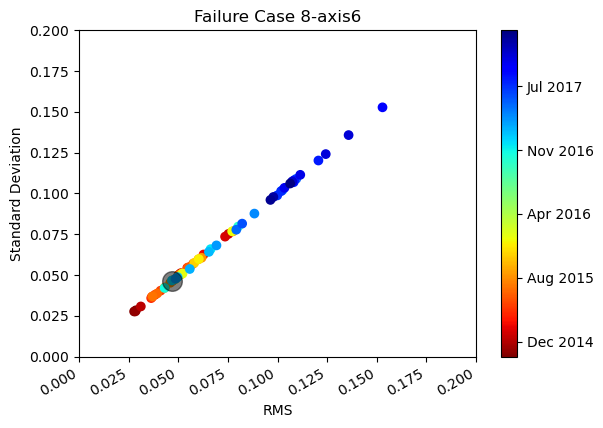

In [171]:
data1 = feature_axis6_FC7
data2 = feature_axis6_FC8
FCname1, FCname2 = 'Failure Case 7-axis6','Failure Case 8-axis6'
plot_figure(data1,FCname1)
plot_figure(data2,FCname2)

(0.0, 0.3)

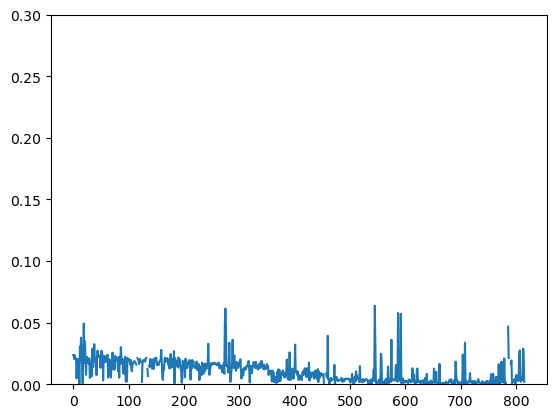

In [46]:

Distance = []
for i in range(21, len(data1)):
    x = data1.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers1))
    Distance.append(dist)
    
plt.plot(Distance)    

plt.ylim(0, .3)

In [ ]:
kmeans = KMeans(n_clusters=1)

# Initiate the reference cluster
ref_cluster = data1[0:20]
ref_array = ref_cluster.to_numpy() 
#Find the centroid of this cluster
reference1 = kmeans.fit(ref_cluster)
centers1 = reference.cluster_centers_
print('centroid of the reference cluster is',centers1)
# Initiate the number N
num = 0
# Create an empty array for the anomaly cluster
new_cluster = np.zeros((0,2))
update_list = []
anomaly_list = []

# Input new signals 
for i in range(20, len(data1)):
    x = data1.iloc[i] 
    dist = (np.linalg.norm(x.to_numpy()-centers1))
    x = x.values.reshape((1,2))    
    if dist > 0.1:
        num = num + 1
        new_cluster = np.append(new_cluster,x, axis=0)
        if num >=5:
            anomaly = kmeans.fit(new_cluster)
            centers_anomaly = anomaly.cluster_centers_
            anomaly_list.append(centers_anomaly)
        else:
            pass
    else:
        
        ref_cluster = np.concatenate((ref_cluster,x), axis=0)
        update = kmeans.fit(ref_cluster)
        center_update = update.cluster_centers_
        update_list.append(center_update)

In [ ]:
anomaly_list
anomaly_cluster = np.zeros((0,2))
for i in anomaly_list:
    anomaly_cluster = np.concatenate((anomaly_cluster,i), axis=0)
# anomaly = pd.DataFrame(a, columns = ['centroid1','centroid2'])
anomaly_cluster.shape
len(anomaly_cluster)
update_cluster = np.zeros((0,2))
for i in update_list:
    update_cluster = np.concatenate((update_cluster,i), axis=0)
update_cluster

In [ ]:
plt.scatter(anomaly_cluster[:,0], anomaly_cluster[:,1],c= range(len(anomaly_cluster)), cmap='YlGn',s=90, alpha=0.5)
plt.colorbar()
plt.scatter(update_cluster[:,0], update_cluster[:,1],c= range(len(update_cluster)), cmap='Blues',s=90, alpha=0.5)
plt.colorbar()
plt.scatter(data1['RMS'], data1['Stv'],c= index, cmap='Reds',s=10, alpha=0.5)
plt.colorbar()
plt.scatter(centers1[:, 0], centers1[:, 1], c='black', s=200, alpha=0.5);

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

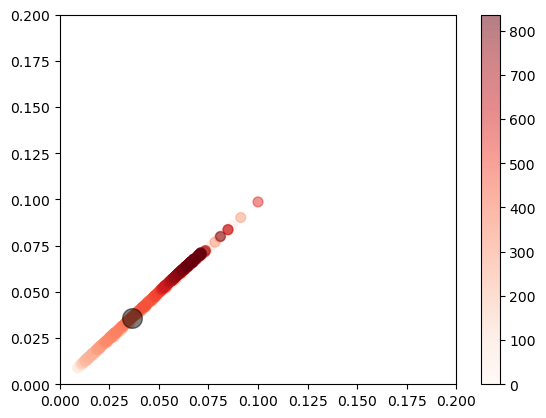

In [53]:
data2 = df2_FC2
p_cluster2 = data2[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster2)



index = np.arange(len(data2))
# p_cluster.shape
plt.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds',s=50, alpha=0.5)
plt.colorbar()
centers2 = kmeans.cluster_centers_

plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=200, alpha=0.5);

plt.xlim(0, .2)
plt.ylim(0, .2)




In [48]:
data2 = df1_FC2

In [49]:

kmeans = KMeans(n_clusters=1)

# Initiate the reference cluster
ref_cluster = data2[0:20]
ref_array = ref_cluster.to_numpy() 
#Find the centroid of this cluster
import numpy as np



reference = kmeans.fit(ref_cluster)
new_cluster = np.empty([0, 2])
centers2 = reference.cluster_centers_
x = data2.iloc[30].values.reshape((1,2))
arr = np.zeros((0,2))  # 定义一个空ndarry数组
arr = np.append(arr, x,axis = 0)
x1 = data2.iloc[31].values.reshape((1,2))
arr = np.append(arr, x1,axis = 0)
print(centers2)

ref_cluster1 = np.append(ref_array,x, axis=0)
ref_cluster1.shape


C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[[0.02454146 0.02453383]]


(21, 2)

In [51]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length
centeroidnp(ref_array)

(0.024541455247163606, 0.024533826880988683)

In [ ]:


from datetime import datetime
n = 0
for i in data.index:
    n = n + 1
    if n == 11:
        print(i)
        break

index_list = []

data1.iloc[21]

In [ ]:
kmeans = KMeans(n_clusters=1)

# Initiate the reference cluster
ref_cluster = data2[0:20]
ref_array = ref_cluster.to_numpy() 
#Find the centroid of this cluster
reference2 = kmeans.fit(ref_cluster)
centers2 = reference.cluster_centers_
print('centroid of the reference cluster is',centers2)
# Initiate the number N
num = 2
# Create an empty array for the anomaly cluster
new_cluster = np.zeros((0,2))
update_list = []
anomaly_list = []

# Input new signals 
for i in range(20, len(data2)):
    x = data2.iloc[i] 
    dist = (np.linalg.norm(x.to_numpy()-centers2))
    x = x.values.reshape((1,2))    
    if dist > 0.15:
        num = num + 1
        new_cluster = np.append(new_cluster,x, axis=0)
        if num >=5:
            #anomaly = kmeans.fit(new_cluster)
            centers_anomaly = centeroidnp(new_cluster)
            print(centers_anomaly)
            anomaly_list.append(centers_anomaly)
        else:
            pass
    else:
        
        ref_cluster = np.append(ref_array,x, axis=0)
        #update = kmeans.fit(ref_cluster)
        center_update = centeroidnp(ref_cluster)
        update_list.append(center_update)



In [ ]:
new_cluster

In [ ]:

length = len(anomaly_list)
anomaly_cluster = np.zeros((length,2))
for i in range(length):
    
    anomaly_cluster[i][0] = anomaly_list[i][0]  
    anomaly_cluster[i][1] = anomaly_list[i][1] 
anomaly_cluster

In [ ]:
length = len(update_list)
update_cluster = np.zeros((length,2))
for i in range(length):
    
    update_cluster[i][0] = update_list[i][0]  
    update_cluster[i][1] = update_list[i][1] 
update_cluster

In [ ]:
anomaly_list
anomaly_cluster = np.zeros((0,2))
for i in anomaly_list:
    anomaly_cluster = np.concatenate((anomaly_cluster,i), axis=0)
# anomaly = pd.DataFrame(a, columns = ['centroid1','centroid2'])
anomaly_cluster.shape
len(anomaly_cluster)
update_cluster = np.zeros((0,2))
for i in update_list:
    update_cluster = np.concatenate((update_cluster,i), axis=0)
update_cluster

In [ ]:

plt.scatter(anomaly_cluster[:,0], anomaly_cluster[:,1],c= range(len(anomaly_cluster)), cmap='YlGn',s=90, alpha=0.5)
plt.colorbar()
# plt.scatter(update_cluster[:,0], update_cluster[:,1],c= range(len(update_cluster)), cmap='Blues',s=90, alpha=0.5)
# plt.colorbar()
plt.scatter(data2['RMS'], data2['Stv'],c= index, cmap='Reds',s=20, alpha=0.5)
plt.colorbar()
plt.scatter(centers2[:, 0], centers2[:, 1], c='black', s=100, alpha=0.5);
plt.scatter(new_cluster[:, 0], new_cluster[:, 1], marker="x", s=10, linewidths=1)
plt.xlim(0, .2)
plt.ylim(0, .2)

In [ ]:

Distance = []
for i in range(21, len(data2)):
    x = data2.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers2))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)



In [ ]:
len(index)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

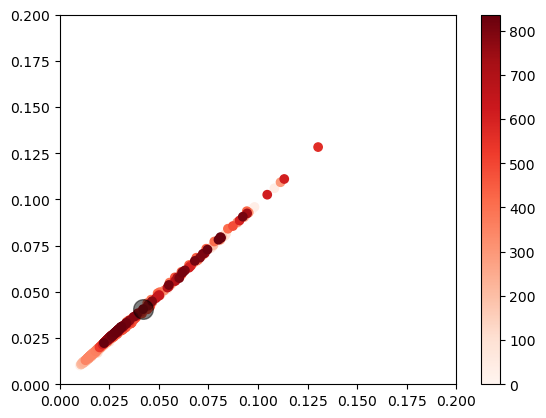

In [54]:
data3 = df3_FC2
p_cluster3 = data3[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster3)

index = np.arange(len(data3))
# p_cluster.shape
plt.scatter(data3['RMS'], data3['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers3 = kmeans.cluster_centers_
plt.scatter(centers3[:, 0], centers3[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .2)
plt.ylim(0, .2)


(0.0, 0.3)

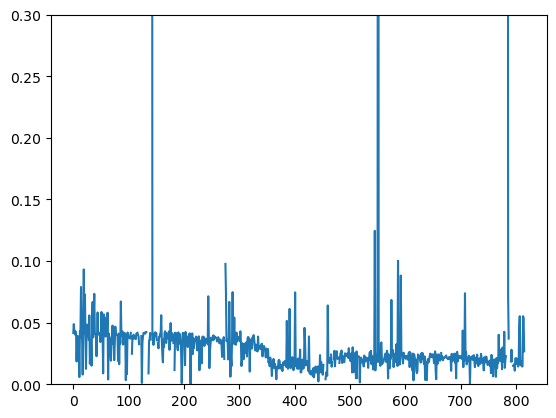

In [65]:
Distance = []
for i in range(21, len(data3)):
    x = data3.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers3))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

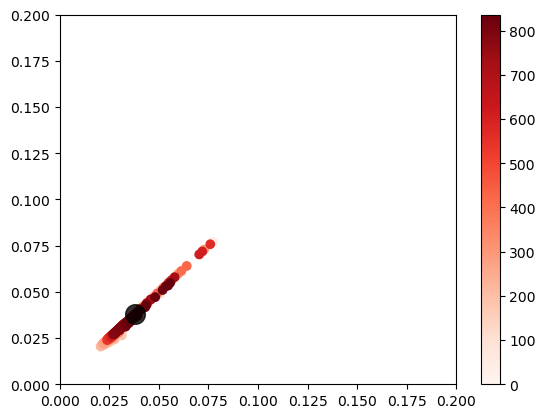

In [56]:
data4 = df4_FC2
p_cluster4 = data4[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster4)



index = np.arange(len(data4))
# p_cluster.shape
plt.scatter(data4['RMS'], data4['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers4 = kmeans.cluster_centers_

plt.scatter(centers4[:, 0], centers4[:, 1], c='black', s=200, alpha=0.8);

plt.xlim(0, .2)
plt.ylim(0, .2)

(0.0, 0.3)

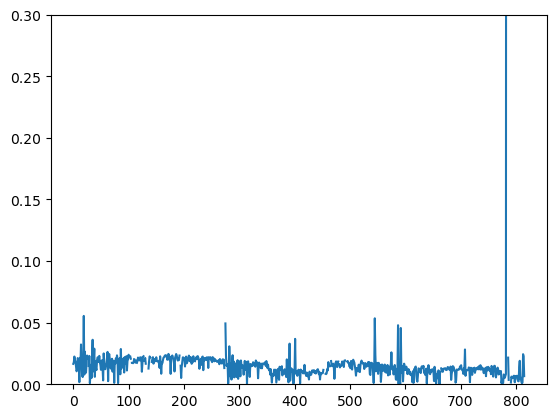

In [68]:
Distance = []
for i in range(21, len(data4)):
    x = data4.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers4))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


(0.0, 0.2)

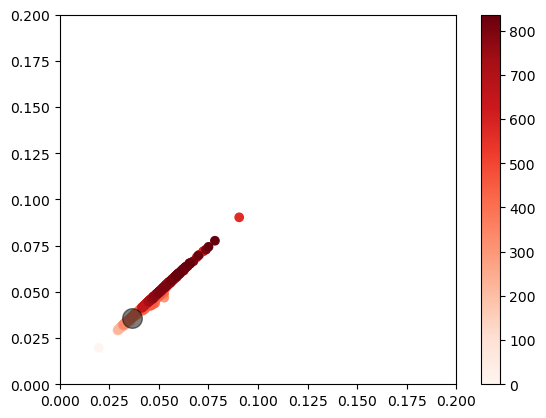

In [82]:
data5 = df5_FC2
p_cluster5 = data5[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster5)


index = np.arange(len(data5))
# p_cluster.shape
plt.scatter(data5['RMS'], data5['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers5 = kmeans.cluster_centers_

plt.scatter(centers5[:, 0], centers5[:, 1], c='black', s=200, alpha=0.5);

plt.xlim(0, .2)
plt.ylim(0, .2)

(0.0, 0.3)

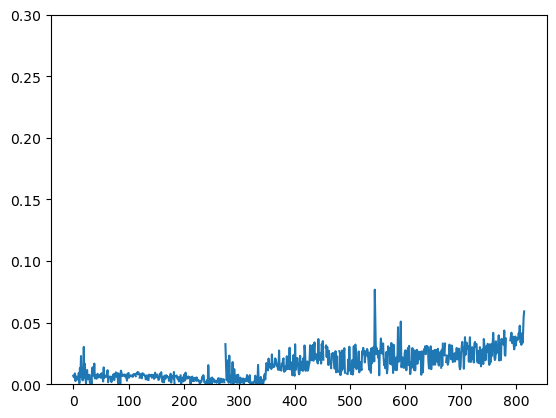

In [84]:
Distance = []
for i in range(21, len(data5)):
    x = data5.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers5))
    Distance.append(dist)
    
plt.plot(Distance)  
plt.ylim(0, .3)

C:\Users\semihua\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


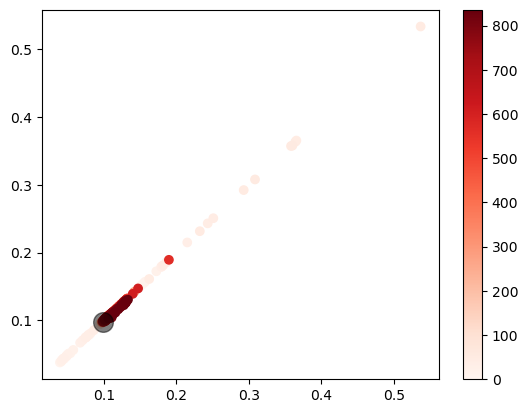

In [79]:
data6 = df6_FC2
p_cluster6 = data6[0:20]
kmeans = KMeans(n_clusters=1)
kmeans.fit(p_cluster6)


index = np.arange(len(data6))
# p_cluster.shape
plt.scatter(data6['RMS'], data6['Stv'],c= index, cmap='Reds')
plt.colorbar()
centers6 = kmeans.cluster_centers_

plt.scatter(centers6[:, 0], centers6[:, 1], c='black', s=200, alpha=0.5);

# plt.xlim(0, .2)
# plt.ylim(0, .2)

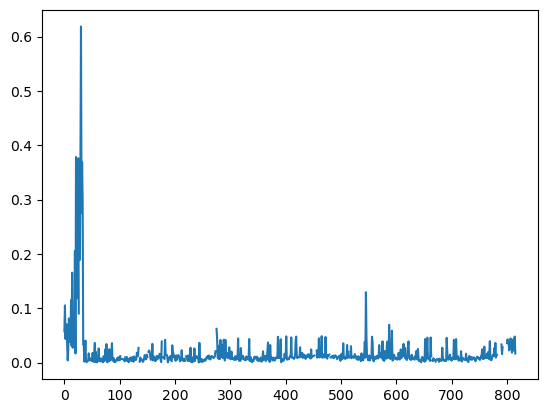

In [80]:
Distance = []
for i in range(21, len(data6)):
    x = data6.iloc[i].to_numpy() 
    dist = (np.linalg.norm(x-centers6))
    Distance.append(dist)
    
plt.plot(Distance)  


In [ ]:
data = df1[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [ ]:
data = df2[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .2)
plt.ylim(0, .2)
print(kmeans.labels_)


In [ ]:
data = df3[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [ ]:
data = df4[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [62]:
data = df5_FC2
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
data = df6[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlim(0, .15)
plt.ylim(0, .1)
print(kmeans.labels_)

In [ ]:
feature = pd.concat([df1[['RMS','Stv']],df2[['RMS','Stv']],df3[['RMS','Stv']],df4[['RMS','Stv']],df5[['RMS','Stv']],df6[['RMS','Stv']]], axis=0)
feature

In [ ]:
pd.set_option('max_colwidth',100)
inertias = []

pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(feature)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(feature)

plt.scatter(feature['RMS'], feature['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [ ]:
import datetime

d = datetime.date(2019, 5, 9)
print(d)
n = 0
df1
df = df1
df  

In [ ]:

df.insert(6, 'Anomaly', value = [True if i < d else False for i in df1.index])
df

In [ ]:
data = df[['RMS','Stv']]
data

inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)

plt.scatter(data['RMS'], data['Stv'],c=kmeans.labels_)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
print(kmeans.labels_)

In [ ]:
File_test = '04-64139_DIAGDATA_20170920_180212__MCC.zip'
feature_list_axis1 = []

from datetime import timedelta
with ZipFile(File_test) as File:
    for file in File.namelist():
        print(file)
        with File.open(file) as f:
            header = read_header(f)
            date = header['date_time']
            print(date.date())
            data = read_data(f)
            mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])
            series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
            plt.figure(figsize=(10,2)) 
            if ax2 in file:
                    # Extract features for axis1
                d = series.normalized_torque()            
                time_index = series.time_index
                   

plt.plot(time_index, d)
plt.show()
plt.hist(d, bins=50)
plt.title('Histogram')
from sklearn.neighbors import KernelDensity




In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
dd = d.reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(dd)
log_dens = kde.score_samples(dd)
ax[1, 1].fill(dd[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")
plt.show()



In [ ]:
File_path = 'C:/Users/semihua/Desktop/Mingjie/test data/FC10_68363858_04-64139'
ax1,ax2,ax3,ax4,ax5,ax6 = 'axis1','axis2','axis3','axis4','axis5','axis6'
d1,d2,d3,d4,d5,d6 = [],[],[],[],[],[]
columns=['axis1','axis2','axis3','axis4','axis5','axis6']
divergence_kullbackleibler = pd.DataFrame(columns=columns)
conditional_entropy = pd.DataFrame(columns=columns)
entropy = pd.DataFrame(columns=columns)
mutual_information = pd.DataFrame(columns=columns)
Jensen_Shannon_divergence = pd.DataFrame(columns=columns)
i = 0    
for loop_file in os.listdir(File_path):
    route = os.path.join(File_path,loop_file)
    print(route)
    if '04-64139_DIAGDATA_20170918_135452_3ece932f-a030-4c95-bd2c-e6d899ed8871_MCC.zip' in route:
        ref1,ref2,ref3,ref4,ref5,ref6 = find_reference_point(route)
    else:
        with ZipFile(route) as File:
            for file in File.namelist():
                with File.open(file) as f:
                    header = read_header(f)
                    data = read_data(f)
                    mode = OperationMode(axis = header['axis'], mech_unit = header['mech_unit'], tool = header['tool'], rob_ax = header['rob_ax'], ext_ax = header['ext_ax'], prog_version = header['prog_version'])    
                    series = MccTimeSeries(data, header['date_time'], header.get('sampling_period', SAMPLING_PERIOD))
                    if ax1 in file:
                    # Extract features for axis1
                        DATA1 = series.normalized_torque()
                        print(ref1)
                        divergence_kullbackleibler.loc[i, 'axis1'] = drv.entropy_conditional(ref1,DATA1)
                        break
#                         Skewness_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.skewness(d1)
#                         Kurtosis_value.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d1)
#                         Crest_factor.loc[i, 'axis1'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d1)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d1)
#                     elif ax2 in file:
#                     # Extract features for axis1
#                         DATA2 = series.torque
#                         d2 = np.concatenate((d2,DATA2), axis=None)
#                         RMS_Value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                         Skewness_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.skewness(d2)
#                         Kurtosis_value.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d2)
#                         Crest_factor.loc[i, 'axis2'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d2)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d2)
#                     elif ax3 in file:
#                     # Extract features for axis1
#                         DATA3 = series.torque
#                         d3 = np.concatenate((d3,DATA3), axis=None)
#                         RMS_Value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                         Skewness_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.skewness(d3)
#                         Kurtosis_value.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d3)
#                         Crest_factor.loc[i, 'axis3'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d3)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d3)
#                     elif ax4 in file:
#                     # Extract features for axis1
#                         DATA4 = series.torque
#                         d4 = np.concatenate((d4,DATA4), axis=None)
#                         RMS_Value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                         Skewness_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.skewness(d4)
#                         Kurtosis_value.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d4)
#                         Crest_factor.loc[i, 'axis4'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d4)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d4)
#                     elif ax5 in file:
#                     # Extract features for axis1
#                         DATA5 = series.torque
#                         d5 = np.concatenate((d5,DATA5), axis=None)
#                         RMS_Value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                         Skewness_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.skewness(d5)
#                         Kurtosis_value.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d5)
#                         Crest_factor.loc[i, 'axis5'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d5)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d5)
#                     elif ax6 in file:
#                     # Extract features for axis1
#                         DATA6 = series.torque
#                         d6 = np.concatenate((d6,DATA6), axis=None)
#                         RMS_Value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#                         Skewness_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.skewness(d6)
#                         Kurtosis_value.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.kurtosis(d6)
#                         Crest_factor.loc[i, 'axis6'] = tsfresh.feature_extraction.feature_calculators.absolute_maximum(d6)/tsfresh.feature_extraction.feature_calculators.root_mean_square(d6)
#             i = i + 1
               

In [ ]:
A = DATA1-ref1
A

In [ ]:
np.sum(rel_entr(DATA1,ref1))


In [ ]:
plt.figure(figsize=(10,2))
plt.plot(DATA1)
plt.plot(ref1)
# drv.entropy_conditional(ref1, DATA1)

In [ ]:
len(DATA1)